# Regression Analysis Cultura Data

This notebook provides an overview of the statistical analysis that complements the main results in our paper. We primarily aim to test the hypothesis that the cultural production score can serve as a proxy for GDP. To evaluate this proposition, we use regression models where GDP is the dependent variable, and cultural production is one of the independent variables. We employ Bayesian Regression Modeling with Bambi—built upon PyMC—for a robust assessment of the correlation between these two variables. But before we delve into the models, we will first load and normalize the data to streamline the processing.

## Data Preparation

In [14]:
import pandas as pd
import numpy as np
import bambi as bmb
import arviz as az

df = pd.read_csv("data_stats_filtered.csv", index_col=0)
df["region_name_id"] = pd.factorize(df["region_name"])[0]
print(f"N = {df.shape[0]}")
df.sample(5)

N = 3228


year     region_name  population_interpolated         N_est  \
2855  1468  United Kingdom                    3.818    104.816607   
314   1676  Eastern Europe                   16.410   3455.752135   
1806  1602   Low countries                    3.020   1474.144380   
1217  1518           Italy                   10.360   2519.923081   
414   1776  Eastern Europe                   25.410  13657.668267   

             lower         upper  score   score_cap   lower_cap   N_est_cap  \
2855     84.448465    127.127662    7.0    1.841366   22.141202   27.482895   
314    3074.521027   3850.574213  154.2    9.379881  186.970707  210.155450   
1806   1359.987124   1593.736295  370.0  122.726882  451.519572  489.426224   
1217   2285.903468   2766.565975  215.4   20.773756  220.420982  242.987782   
414   12578.799687  14789.529677  608.8   23.823621  492.231057  534.497143   

       upper_cap  gdp_per_capita  inclusive  restricted  region_name_id  
2855   33.334438            1669          1           1               9  
314   234.165967             848          1           1               1  
1806  529.139172            3266          1           1               6  
1217  266.771822            3103          1           1               4  
414   578.832203             995          1           1               1

We have GDP data for the following 10 regions:

In [19]:
df["region_name"].value_counts()

region_name
United Kingdom      590
Nordic countries    541
France              532
Italy               532
Low countries       487
Eastern Europe      423
Spain                58
Chinese world        46
Japan                12
German world          7
Name: count, dtype: int64

We apply a logarithmic transformation to the GDP to account for its exponential growth, as our interest lies in variables that maintain a linear correlation with GDP. We also center this at 1, which aids in straightforward interpretation. We employ the same strategy to both the production score (`score`) and the bias-corrected production score (`N_est`):

In [20]:
# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["score_cap_log"] = np.log(df["score_cap"])
df["N_est_log"] = np.log(df["N_est"])
df["N_est_cap_log"] = np.log(df["N_est_cap"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["score_cap_log_std"] = np.log(df["score_cap"]) / df["score_cap_log"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()
df["N_est_cap_log_std"] = np.log(df["N_est_cap"]) / df["N_est_cap_log"].mean()
df["log_gdp"] = np.log(df["gdp_per_capita"])
df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df.sample(5)

year     region_name  population_interpolated        N_est        lower  \
1801  1597   Low countries                   2.9745  1457.536039  1342.853097   
3198  1811  United Kingdom                  13.0050  9964.609610  9504.015664   
1265  1566           Italy                  11.3200  2930.937077  2685.485876   
573   1383          France                  11.8500   165.407361   136.720345   
274   1636  Eastern Europe                  15.5000  2554.571959  2245.431192   

             upper   score   score_cap   lower_cap   N_est_cap  ...  \
1801   1577.606726   347.0  116.372327  450.534720  489.021470  ...   
3198  10426.410983  1347.6  103.356140  728.696254  764.006699  ...   
1265   3197.634413   231.8   20.492481  237.394678  259.093491  ...   
573     196.167620    12.9    1.091304   11.552067   13.975090  ...   
274    2868.206303   120.4    7.767742  144.866529  164.811094  ...   

      score_log  score_cap_log  N_est_log  N_est_cap_log  score_log_std  \
1801   5.849325       4.756795   7.284503       6.192406       1.352324   
3198   7.206081       4.638181   9.206795       6.638577       1.665996   
1265   5.445875       3.020058   7.983077       5.557189       1.259049   
573    2.557227       0.087374   5.108411       2.637276       0.591213   
274    4.790820       2.049980   7.845640       5.104800       1.107605   

      score_cap_log_std  N_est_log_std  N_est_cap_log_std   log_gdp  \
1801           1.974139       1.077642           1.278379  8.409608   
3198           1.924912       1.362018           1.370488  8.130648   
1265           1.253368       1.180986           1.147243  7.852828   
573            0.036261       0.755719           0.544447  7.473637   
274            0.850771       1.160654           1.053850  6.829794   

      log_gdp_std  
1801     1.119819  
3198     1.082672  
1265     1.045678  
573      0.995185  
274      0.909451  

[5 rows x 26 columns]

The distribution of the logged GDP values is clearly trimodal:

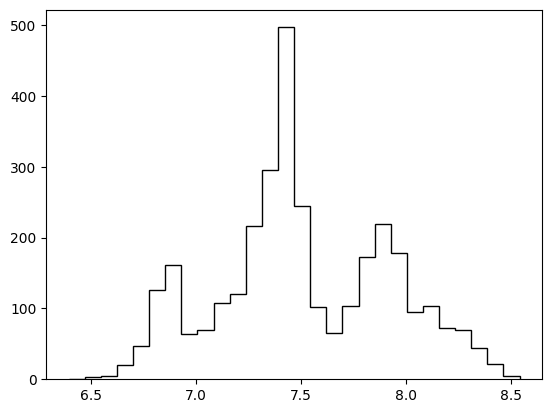

In [24]:
import matplotlib.pyplot as plt

plt.hist(df["log_gdp"].values, histtype="step", color="k", bins="fd");

We observe an intriguing trimodal structure. It was suggested by Charles that this might be due to "the fact that the Maddison data always tend to have an estimation for a region at date year=1 and then jump up to over year=1000". Filtering these instances, doesn't seem to alter the trimodal structure, however:

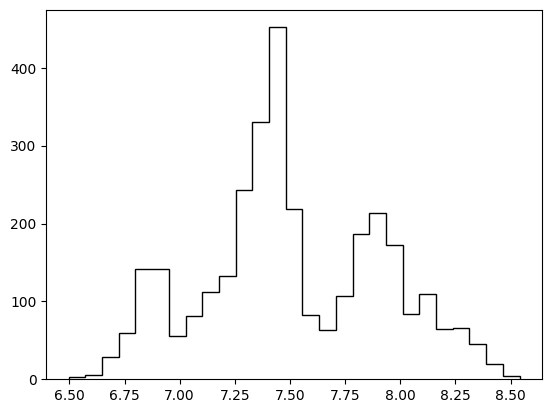

In [25]:
plt.hist(df.loc[df["year"] >= 1000, "log_gdp"].values, histtype="step", color="k", bins="fd");

The trimodality of the data is somewhat hidden when plotting against the unnormalized score and bias-corrected score. However, after log transformation, the structure becomes visible again:

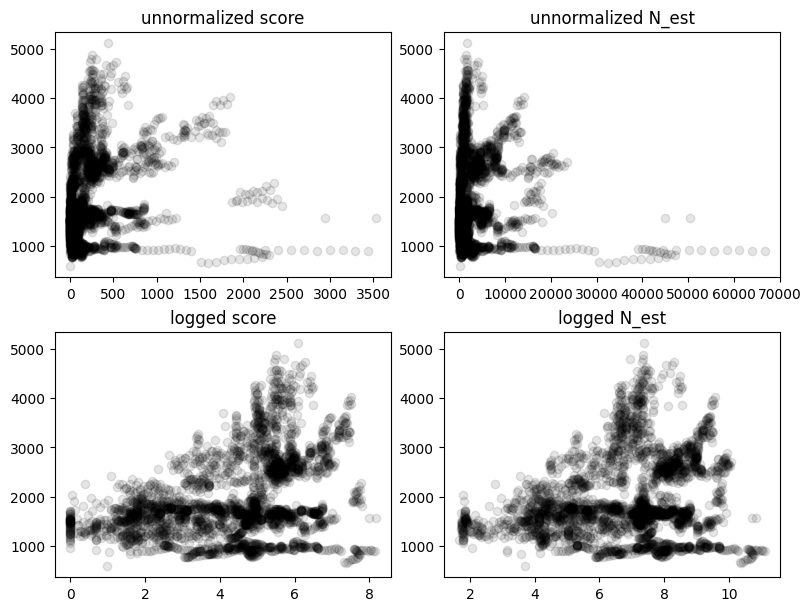

In [26]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), constrained_layout=True)
axes = axes.flatten()

axes[0].scatter(df["score"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[0].set_title("unnormalized score")

axes[1].scatter(df["N_est"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[1].set_title("unnormalized N_est")

axes[2].scatter(df["score_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[2].set_title("logged score")

axes[3].scatter(df["N_est_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[3].set_title("logged N_est");

## Regression Analysis: Setting a Baseline

In our attempt to model the relationship between per capita GDP and cultural production, we utilize linear regression models. By progressively developing more intricate models, we evaluate them via approximate leave-one-out cross-validation (LOO). Initially, we establish a global relationship model that doesn't account for any regional differentiation. The model is specified as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \beta x_i \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In this model, $\alpha$ stands for the intercept and $\beta$ denotes the coefficient of the production score.

In [27]:
models = {}

The model is easily translated to Bambi with:

In [28]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score = bmb.Model(
    f"log_gdp_std ~ score_log_std", df, family="gaussian", priors=priors)

The model graph looks as follows:

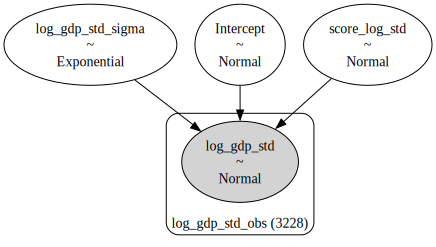

In [29]:
m_score.build()
m_score.graph()

Since this is a relatively simple model, we tune the sampler for 1000 timesteps and draw 1000 samples from the posterior:

In [30]:
fit_score = m_score.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ score_log_std"] = fit_score

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
/usr/local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


A quick summary of the model wth ArViz indicates that globally, the cultural production score has small yet pronounced effect:

In [31]:
az.summary(models["gdp ~ score_log_std"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          0.957  0.002   0.953    0.962        0.0      0.0   
score_log_std      0.043  0.002   0.038    0.047        0.0      0.0   
log_gdp_std_sigma  0.052  0.001   0.050    0.053        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
Intercept            5024.0    2863.0    1.0  
score_log_std        4955.0    2615.0    1.0  
log_gdp_std_sigma    4849.0    3038.0    1.0

However, the model fit is not particularly good. To further examine this, we conduct a posterior predictive check where we plot the estimated posterior against the observed GDP distribution. Evidently, the model falls short in fitting the trimodal structure of the data:

/usr/local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


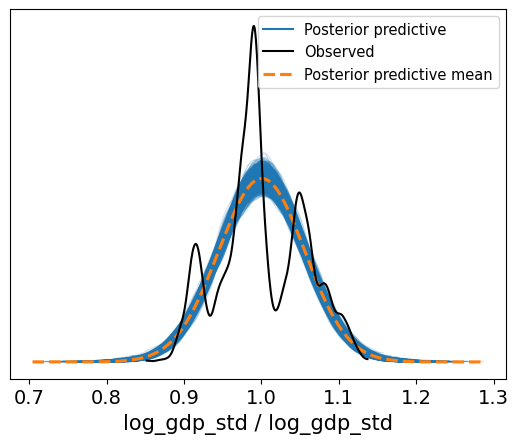

In [32]:
m_score.predict(fit_score, kind="pps")
az.plot_ppc(fit_score);

When we map the predictive posterior slopes against the empirical data in a scatter plot, it reaffirms our previous observation: the model is inadequate in accurately characterizing the data:

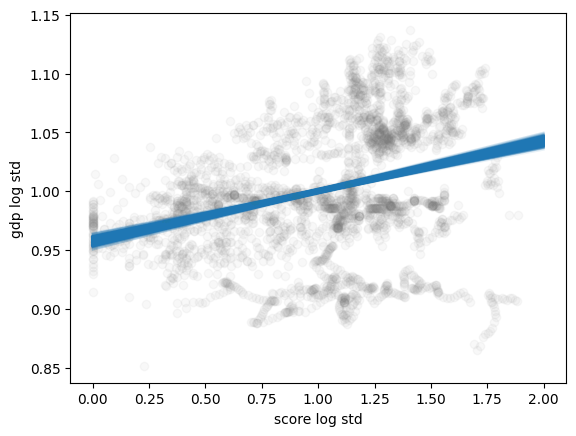

In [33]:
score_log_std_new = np.linspace(0, 2, num=200)
m_score.predict(fit_score, data=pd.DataFrame({"score_log_std": score_log_std_new}))
gdp = fit_score.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(score_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["score_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="score log std", ylabel="gdp log std");

We juxtapose this model with another where we employ the bias-corrected cultural production score as opposed to the unnormalized score. While the model specification remains consistent, its implementation unfolds as follows:

In [39]:
m_est = bmb.Model(
    f"log_gdp_std ~ N_est_log_std", df, family="gaussian", priors=priors)
fit_est = m_est.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ N_est_log_std"] = fit_est

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


Similar to the previous analysis, a cursory analysis of the new model seems to suggest a slightly weaker but still positive correlation between the cultural production score and GDP:

In [40]:
az.summary(models["gdp ~ N_est_log_std"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          0.967  0.004   0.961    0.974        0.0      0.0   
N_est_log_std      0.033  0.003   0.026    0.039        0.0      0.0   
log_gdp_std_sigma  0.054  0.001   0.052    0.055        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
Intercept            6106.0    3508.0    1.0  
N_est_log_std        6092.0    3440.0    1.0  
log_gdp_std_sigma    6453.0    2857.0    1.0

This relationship is visualized in the following graph:

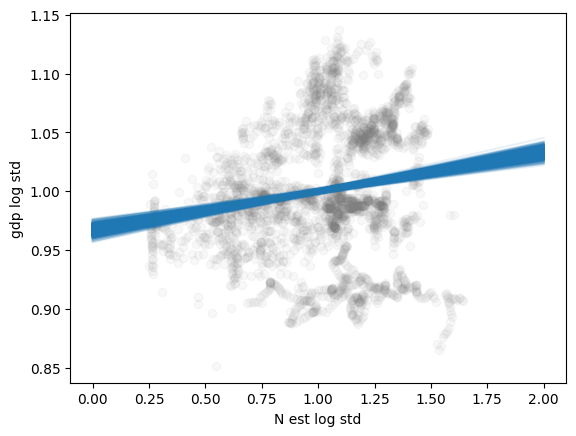

In [41]:
N_est_log_std_new = np.linspace(0, 2, num=200)
m_est.predict(fit_est, data=pd.DataFrame({"N_est_log_std": N_est_log_std_new}))
gdp = fit_est.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(N_est_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["N_est_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="N est log std", ylabel="gdp log std");

However, as indicated by the posterior predictive check, the model fit continues to disappointingly underperform:

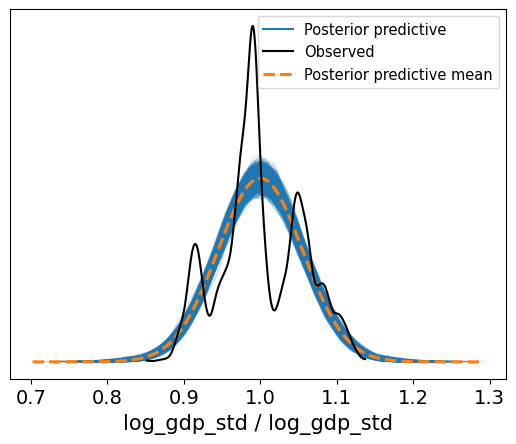

In [42]:
m_est.predict(fit_est, kind="pps")
az.plot_ppc(fit_est);

We utilize WAIC (Widely Applicable Information Criterion) or LOO to compare these models. This evaluation shows that the model incorporating the bias-corrected production variable does not perform better than one using the unnormalized variable. Nevertheless, as previously observed, both models exhibit subpar performance, suggesting caution in drawing any conclusions from this comparison. Overall, there appears evidence for a mildly positive relationship between the variables.

In [43]:
waic_compare = az.compare(models, ic='WAIC')
waic_compare

rank    elpd_waic    p_waic   elpd_diff        weight  \
gdp ~ score_log_std     0  4991.774221  2.669818    0.000000  1.000000e+00   
gdp ~ N_est_log_std     1  4862.284379  2.614217  129.489842  1.560352e-11   

                            se       dse  warning scale  
gdp ~ score_log_std  37.680244  0.000000    False   log  
gdp ~ N_est_log_std  35.902633  8.782674    False   log

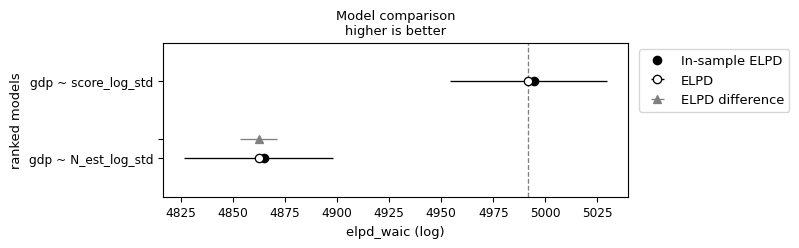

In [44]:
az.plot_compare(waic_compare, insample_dev=True);

## Hierarchical Linear Models

We now progress to a more nuanced analysis that leverages the inherent structure of our data, employing hierarchical linear models. Initially, we implement a rudimentary hierarchical model that only features varying intercepts for regions. This approach models each region as a distinct distribution, each contributing to the global intercept. The specification of the model is as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]}\\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In [45]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_vi = bmb.Model(
    "log_gdp_std ~ 1 + (1|region_name)", df, family="gaussian", noncentered=True, priors=priors)
m_vi

       Formula: log_gdp_std ~ 1 + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

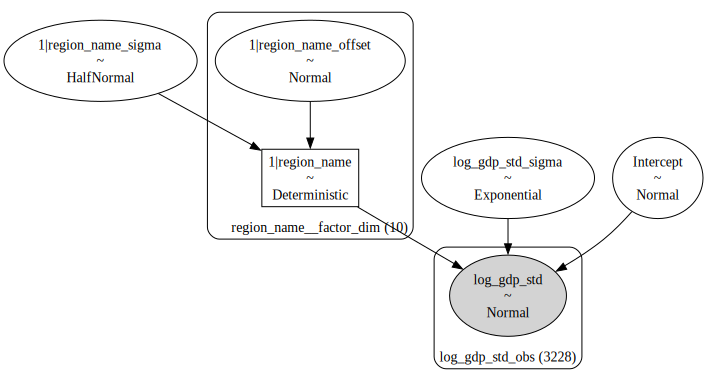

In [46]:
m_vi.build()
m_vi.graph()

The complexity of this model increases slightly, particularly due to the limited data points available for certain regions. Consequently, it's advisable to generate more posterior samples than in the previous models and proceed with a degree of caution while exploring the posterior during the sampling process:

In [47]:
m_vi_fit = m_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,  # more cautious exploration of the posterior
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ (1|region_name)"] = m_vi_fit
az.summary(m_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 131 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.981  0.019   0.945    1.017      0.001   
log_gdp_std_sigma                0.026  0.000   0.026    0.027      0.000   
1|region_name_sigma              0.059  0.017   0.034    0.092      0.000   
1|region_name[Chinese world]    -0.037  0.020  -0.072    0.001      0.001   
1|region_name[Eastern Europe]   -0.067  0.019  -0.103   -0.031      0.001   
1|region_name[France]            0.008  0.019  -0.029    0.043      0.001   
1|region_name[German world]     -0.002  0.021  -0.041    0.040      0.001   
1|region_name[Italy]             0.073  0.019   0.037    0.109      0.001   
1|region_name[Japan]            -0.059  0.020  -0.096   -0.020      0.001   
1|region_name[Low countries]     0.084  0.019   0.048    0.120      0.001   
1|region_name[Nordic countries] -0.003  0.019  -0.038    0.033      0.001   
1|region_name[Spain]            -0.014  0.019  -0.051    0.022      0.001   
1|region_name[United Kingdom]    0.019  0.019  -0.018    0.054      0.001   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1369.0    1730.0    1.0  
log_gdp_std_sigma                    0.0    4836.0    4213.0    1.0  
1|region_name_sigma                  0.0    1383.0    2206.0    1.0  
1|region_name[Chinese world]         0.0    1392.0    1928.0    1.0  
1|region_name[Eastern Europe]        0.0    1370.0    1745.0    1.0  
1|region_name[France]                0.0    1372.0    1739.0    1.0  
1|region_name[German world]          0.0    1556.0    2128.0    1.0  
1|region_name[Italy]                 0.0    1369.0    1760.0    1.0  
1|region_name[Japan]                 0.0    1501.0    2100.0    1.0  
1|region_name[Low countries]         0.0    1375.0    1711.0    1.0  
1|region_name[Nordic countries]      0.0    1367.0    1678.0    1.0  
1|region_name[Spain]                 0.0    1441.0    1820.0    1.0  
1|region_name[United Kingdom]        0.0    1376.0    1705.0    1.0

The sampling process appears to be effective, characterized by $\hat{r}$ scores hovering around 1 and a satisfactory effective sample size. Below, we provide a forest plot for the varying intercepts. Bear in mind that due to the construction of the model (non-centered), these intercepts should be interpreted as deviations from the global mean intercept, which is not displayed here.

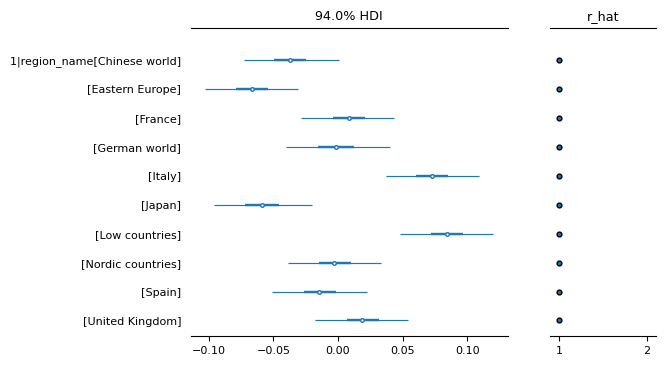

In [48]:
az.plot_forest(
    data=m_vi_fit, 
    figsize=(6, 4), 
    var_names=["1|region_name"], 
    r_hat=True, 
    combined=True, 
    textsize=8
);

Merely by incorporating the hierarchical levels associated with regions, we notice a significant improvement in the model fit, as illustrated in the subsequent posterior predictive check plot:

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


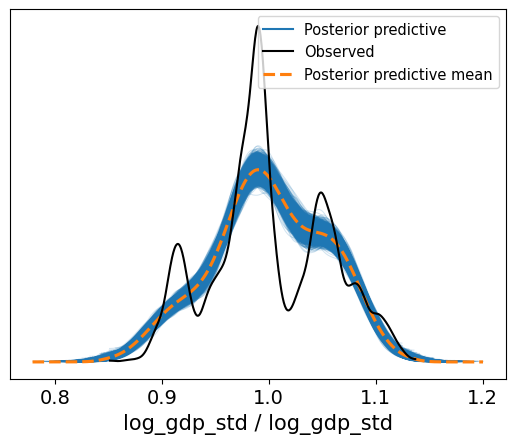

In [49]:
m_vi.predict(m_vi_fit, kind="pps")
az.plot_ppc(m_vi_fit);

### Varying Regions with Global Cultural Production Relationship

It thus seems that allowing variation in GDP per region is useful. We continue experimenting, adding the cultural production both regular and corrected to the model. The model description then becomes:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} \beta x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

Note that this is essentially the model proposed in the current version of the paper without the variable time. However, including time as a linear predictor will not change the most important lessons of the models below.

In [50]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vi = bmb.Model(
    "log_gdp_std ~ score_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True, 
    priors=priors
)
m_score_vi

       Formula: log_gdp_std ~ score_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

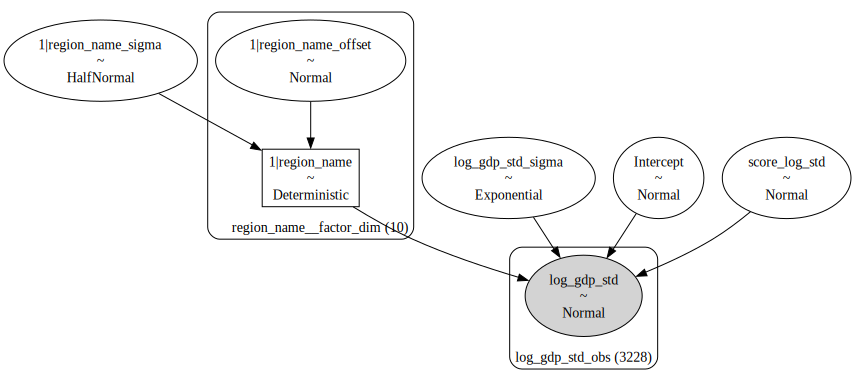

In [51]:
m_score_vi.build()
m_score_vi.graph()

In [52]:
m_score_vi_fit = m_score_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ score_log_std + (1|region_name)"] = m_score_vi_fit
az.summary(m_score_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 188 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.946  0.018   0.913    0.980        0.0   
score_log_std                    0.035  0.001   0.032    0.037        0.0   
log_gdp_std_sigma                0.023  0.000   0.022    0.024        0.0   
1|region_name_sigma              0.056  0.015   0.032    0.085        0.0   
1|region_name[Chinese world]    -0.027  0.018  -0.063    0.006        0.0   
1|region_name[Eastern Europe]   -0.071  0.018  -0.106   -0.038        0.0   
1|region_name[France]            0.006  0.018  -0.028    0.041        0.0   
1|region_name[German world]     -0.022  0.019  -0.061    0.013        0.0   
1|region_name[Italy]             0.065  0.018   0.031    0.099        0.0   
1|region_name[Japan]            -0.047  0.019  -0.084   -0.012        0.0   
1|region_name[Low countries]     0.082  0.018   0.048    0.115        0.0   
1|region_name[Nordic countries]  0.007  0.018  -0.026    0.042        0.0   
1|region_name[Spain]            -0.012  0.018  -0.046    0.022        0.0   
1|region_name[United Kingdom]    0.021  0.018  -0.014    0.054        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1623.0    1895.0   1.00  
score_log_std                        0.0    5843.0    4554.0   1.00  
log_gdp_std_sigma                    0.0    5227.0    4397.0   1.00  
1|region_name_sigma                  0.0    1517.0    2870.0   1.01  
1|region_name[Chinese world]         0.0    1647.0    2026.0   1.00  
1|region_name[Eastern Europe]        0.0    1620.0    1920.0   1.00  
1|region_name[France]                0.0    1616.0    1973.0   1.00  
1|region_name[German world]          0.0    1880.0    2201.0   1.00  
1|region_name[Italy]                 0.0    1617.0    1918.0   1.00  
1|region_name[Japan]                 0.0    1782.0    2179.0   1.00  
1|region_name[Low countries]         0.0    1616.0    1998.0   1.00  
1|region_name[Nordic countries]      0.0    1621.0    1880.0   1.00  
1|region_name[Spain]                 0.0    1658.0    2042.0   1.00  
1|region_name[United Kingdom]        0.0    1620.0    1944.0   1.00

Once again, the sampling appears to be successful, reflected by desirable $\hat{r}$ values and substantial effective sample sizes. The findings hint at a minimal positive global correlation between cultural production and GDP (0.035 CI [0.032, 0.037]). It seems that the model fit has experienced a slight enhancement

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


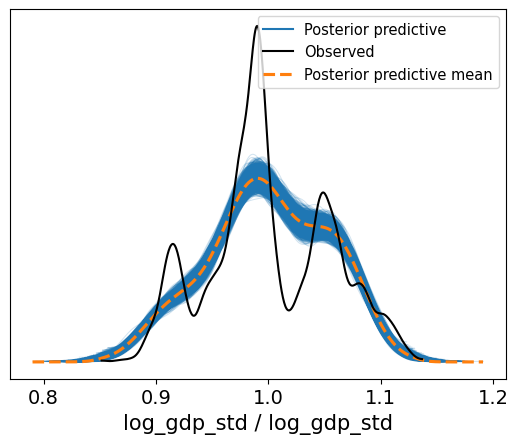

In [53]:
m_score_vi.predict(m_score_vi_fit, kind="pps")
az.plot_ppc(m_score_vi_fit);

Nevertheless, plotting the predictions against the observed data for each region provides more insightful information. This is depicted in the plot below, wherein it's evident that a global predictor of cultural production falls short in fitting the data accurately. Many regions, such as the Low Countries, the Chinese World, or Portugal, exhibit significant residuals, leaving a considerable amount of variation unexplained. Crucially, by assuming the relationship to be exclusively global, we imply it can only be unidirectional --- an assumption that, as we'll soon discover, may not necessarily hold true.

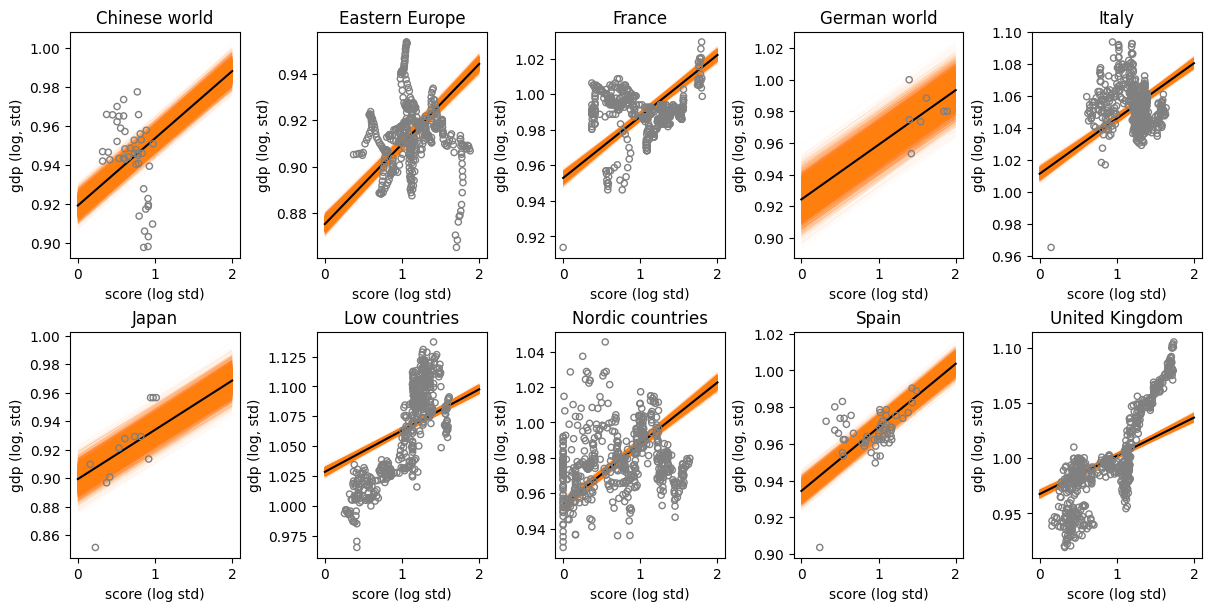

In [55]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

Here's another visualization of the posterior predictions: the intercepts differ, but the slope (_by design_) is the same, and thus always positive:

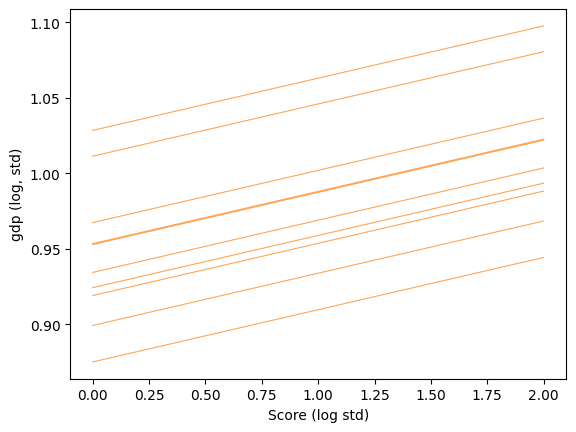

In [56]:
posterior = az.extract(m_score_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["score_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("Score (log std)");

We perform the same analysis, swapping the cultural production score for the bias-corrected score:

In [57]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vi = bmb.Model(
    "log_gdp_std ~ N_est_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors)
m_est_vi

       Formula: log_gdp_std ~ N_est_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [58]:
m_est_vi_fit = m_est_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (1|region_name)"] = m_est_vi_fit
az.summary(m_est_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 190 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.937  0.020   0.900    0.974      0.001   
N_est_log_std                    0.044  0.002   0.041    0.047      0.000   
log_gdp_std_sigma                0.024  0.000   0.023    0.025      0.000   
1|region_name_sigma              0.058  0.018   0.032    0.090      0.000   
1|region_name[Chinese world]    -0.026  0.020  -0.064    0.011      0.001   
1|region_name[Eastern Europe]   -0.074  0.020  -0.111   -0.037      0.001   
1|region_name[France]            0.007  0.020  -0.029    0.045      0.001   
1|region_name[German world]     -0.022  0.021  -0.064    0.015      0.001   
1|region_name[Italy]             0.066  0.020   0.028    0.103      0.001   
1|region_name[Japan]            -0.049  0.021  -0.089   -0.012      0.001   
1|region_name[Low countries]     0.086  0.020   0.050    0.124      0.001   
1|region_name[Nordic countries]  0.005  0.020  -0.032    0.042      0.001   
1|region_name[Spain]            -0.013  0.020  -0.054    0.021      0.001   
1|region_name[United Kingdom]    0.021  0.020  -0.016    0.058      0.001   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1287.0    1913.0    1.0  
N_est_log_std                        0.0    5648.0    4077.0    1.0  
log_gdp_std_sigma                    0.0    6145.0    4405.0    1.0  
1|region_name_sigma                  0.0    1621.0    2474.0    1.0  
1|region_name[Chinese world]         0.0    1328.0    2013.0    1.0  
1|region_name[Eastern Europe]        0.0    1293.0    1998.0    1.0  
1|region_name[France]                0.0    1298.0    1944.0    1.0  
1|region_name[German world]          0.0    1465.0    2232.0    1.0  
1|region_name[Italy]                 0.0    1298.0    1913.0    1.0  
1|region_name[Japan]                 0.0    1406.0    1863.0    1.0  
1|region_name[Low countries]         0.0    1296.0    1936.0    1.0  
1|region_name[Nordic countries]      0.0    1295.0    1916.0    1.0  
1|region_name[Spain]                 0.0    1311.0    1905.0    1.0  
1|region_name[United Kingdom]        0.0    1296.0    1980.0    1.0

The fit appears to bear similarity to the prior model, and once more, the incorporated unidirectional relationship yields comparatively large residuals.

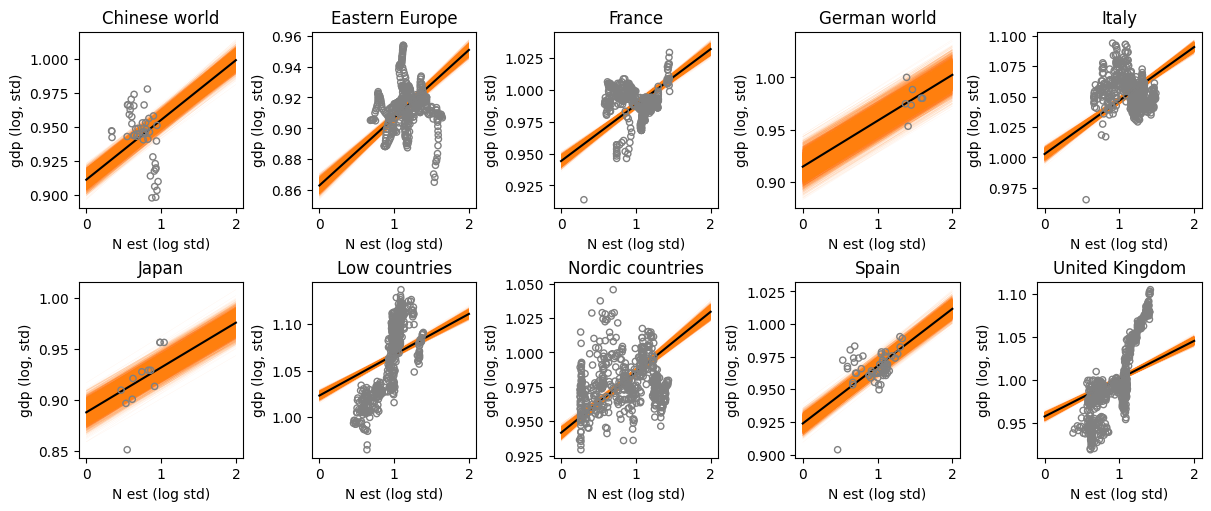

In [59]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N est (log std)", title=region_name)

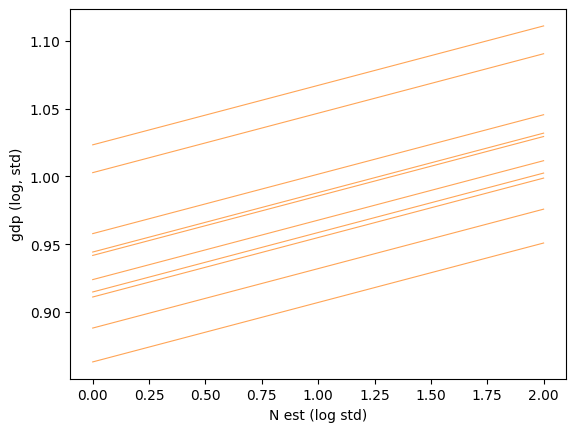

In [60]:
posterior = az.extract(m_est_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("N est (log std)");

#### Model comparison

We undertake a comparison of all models explored thus far, this time employing approximate leave-one-out cross-validation (LOO). The model incorporating varying intercepts on region and using cultural score as a global predictor appears to best fit the data. As expected, it is closely followed by the model utilizing bias-corrected cultural production scores. All models featuring varying intercepts significantly outperform those with a singular global intercept. The results are demonstrated in the subsequent table and accompanying figure.

In [61]:
waic_compare = az.compare(models, ic='LOO')

In [62]:
waic_compare

rank     elpd_loo      p_loo  \
log_gdp_std ~ score_log_std + (1|region_name)     0  7589.360798  11.518810   
log_gdp_std ~ N_est_log_std + (1|region_name)     1  7451.883351  11.315484   
log_gdp_std ~ (1|region_name)                     2  7146.618238  10.083927   
gdp ~ score_log_std                               3  4991.770865   2.673174   
gdp ~ N_est_log_std                               4  4862.281196   2.617400   

                                                 elpd_diff    weight  \
log_gdp_std ~ score_log_std + (1|region_name)     0.000000  0.982174   
log_gdp_std ~ N_est_log_std + (1|region_name)   137.477447  0.000000   
log_gdp_std ~ (1|region_name)                   442.742560  0.017826   
gdp ~ score_log_std                            2597.589934  0.000000   
gdp ~ N_est_log_std                            2727.079603  0.000000   

                                                      se        dse  warning  \
log_gdp_std ~ score_log_std + (1|region_name)  41.155950   0.000000    False   
log_gdp_std ~ N_est_log_std + (1|region_name)  43.842027   8.424686    False   
log_gdp_std ~ (1|region_name)                  54.531812  30.076862    False   
gdp ~ score_log_std                            37.680358  50.156948    False   
gdp ~ N_est_log_std                            35.902716  48.118877    False   

                                              scale  
log_gdp_std ~ score_log_std + (1|region_name)   log  
log_gdp_std ~ N_est_log_std + (1|region_name)   log  
log_gdp_std ~ (1|region_name)                   log  
gdp ~ score_log_std                             log  
gdp ~ N_est_log_std                             log

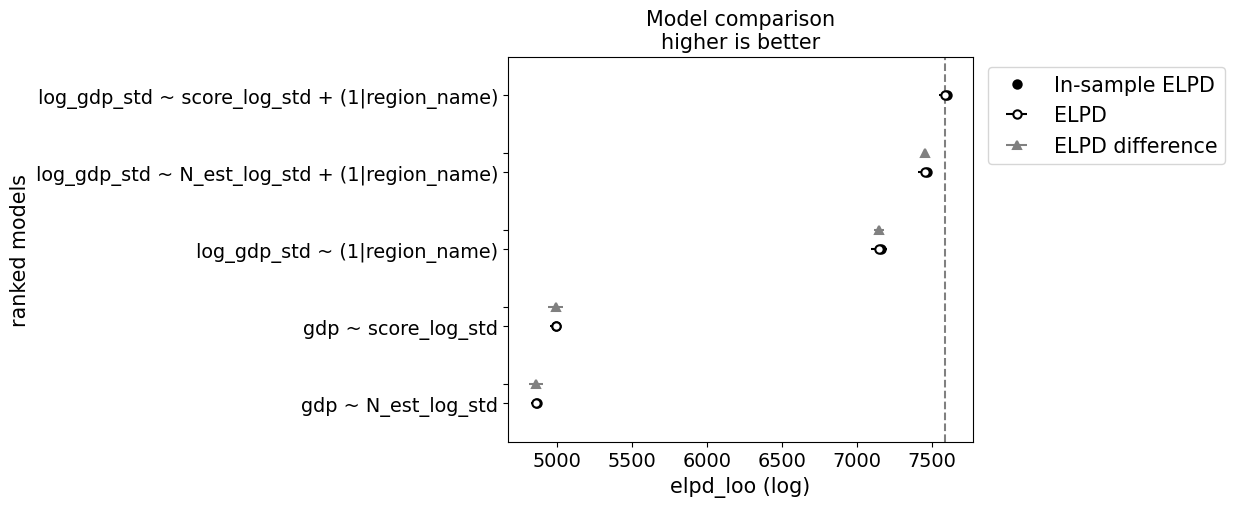

In [63]:
az.plot_compare(waic_compare, insample_dev=True);

/usr/local/lib/python3.11/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)


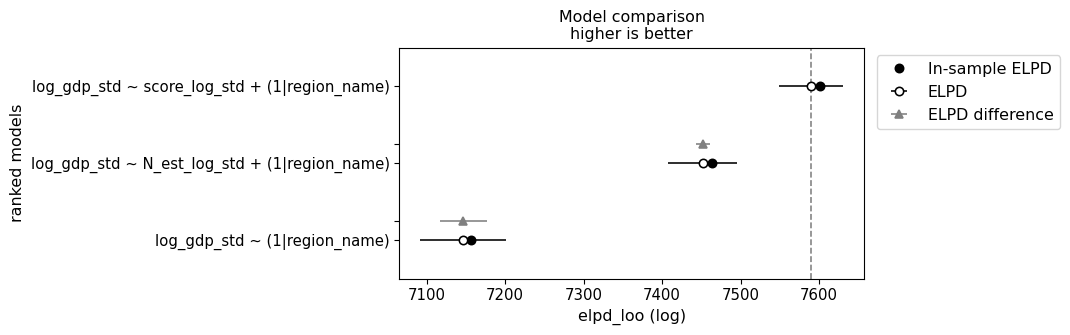

In [64]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("1|region_name")], insample_dev=True);

### Varying Slopes for Cultural Production in Different Regions

In our previous analysis, we presumed a global, uniform effect of cultural production on GDP per capita. However, upon observing significant discrepancies in the GDP intercepts per region, it's plausible that the relationship's slope between the cultural production score and GDP also varies. To cater to this, we construct a varying slope model with the following specification:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} + (\beta + \beta_{\text{region}[i]}) x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\alpha}) \\
\beta_\text{region} & \sim \text{Normal}(0, \sigma_{\beta}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\alpha} & \sim \text{HalfNormal}(1) \\
\sigma_{\beta} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

As daunting as this might seem, it can be implemented relatively straightforward, as shown below. Also note that we could further improve the model by modeling the dependence of the priors on the varying slopes and intercepts. For now we treat them as independent priors, which may not be the most efficient way to do it.

In [65]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vs = bmb.Model(
    "log_gdp_std ~ score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_vs

       Formula: log_gdp_std ~ score_log_std + (score_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            score_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

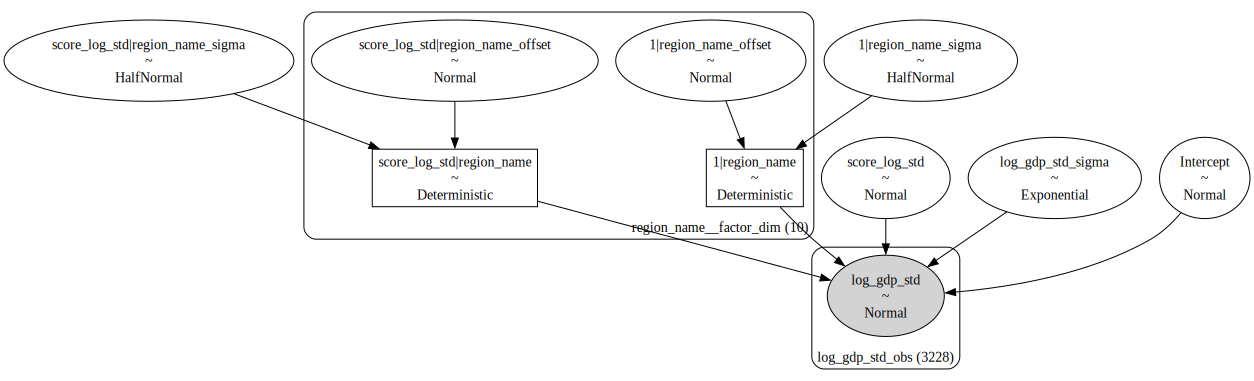

In [66]:
m_score_vs.build()
m_score_vs.graph()

Despite a considerable surge in the model's complexity, efficient sampling persists, marked by commendable $\hat{r}$ values and satisfactory effective sample sizes. The model's summary is provided below. A key observation we promptly make is the elimination of the unmistakably positive main, global effect of the cultural production score. Instead, it intersects 0 within the 97% confidence intervals, suggesting the effect is not solely positive. We'll elaborate on this further in the ensuing section.

In [67]:
m_score_vs_fit = m_score_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_log_std + (score_log_std|region_name)"] = m_score_vs_fit
az.summary(m_score_vs_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 616 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  \
Intercept                                    0.960  0.021   0.921    0.998   
score_log_std                                0.022  0.018  -0.014    0.055   
log_gdp_std_sigma                            0.017  0.000   0.017    0.017   
1|region_name_sigma                          0.060  0.018   0.033    0.092   
score_log_std|region_name_sigma              0.055  0.016   0.030    0.085   
1|region_name[Chinese world]                 0.020  0.022  -0.023    0.062   
1|region_name[Eastern Europe]               -0.042  0.021  -0.083   -0.004   
1|region_name[France]                        0.026  0.021  -0.013    0.064   
1|region_name[German world]                  0.000  0.038  -0.072    0.074   
1|region_name[Italy]                         0.104  0.021   0.063    0.142   
1|region_name[Japan]                        -0.083  0.023  -0.130   -0.043   
1|region_name[Low countries]                 0.006  0.021  -0.032    0.045   
1|region_name[Nordic countries]              0.014  0.021  -0.025    0.052   
1|region_name[Spain]                        -0.008  0.022  -0.049    0.033   
1|region_name[United Kingdom]               -0.037  0.021  -0.076    0.001   
score_log_std|region_name[Chinese world]    -0.074  0.022  -0.115   -0.032   
score_log_std|region_name[Eastern Europe]   -0.024  0.019  -0.060    0.010   
score_log_std|region_name[France]           -0.018  0.019  -0.053    0.016   
score_log_std|region_name[German world]     -0.010  0.028  -0.062    0.042   
score_log_std|region_name[Italy]            -0.030  0.019  -0.064    0.006   
score_log_std|region_name[Japan]             0.049  0.024   0.005    0.093   
score_log_std|region_name[Low countries]     0.072  0.019   0.037    0.106   
score_log_std|region_name[Nordic countries] -0.016  0.018  -0.052    0.017   
score_log_std|region_name[Spain]            -0.006  0.020  -0.044    0.030   
score_log_std|region_name[United Kingdom]    0.061  0.018   0.026    0.095   

                                             mcse_mean  mcse_sd  ess_bulk  \
Intercept                                        0.000      0.0    2487.0   
score_log_std                                    0.000      0.0    2604.0   
log_gdp_std_sigma                                0.000      0.0    9293.0   
1|region_name_sigma                              0.000      0.0    3244.0   
score_log_std|region_name_sigma                  0.000      0.0    2674.0   
1|region_name[Chinese world]                     0.000      0.0    2708.0   
1|region_name[Eastern Europe]                    0.000      0.0    2502.0   
1|region_name[France]                            0.000      0.0    2499.0   
1|region_name[German world]                      0.001      0.0    5255.0   
1|region_name[Italy]                             0.000      0.0    2541.0   
1|region_name[Japan]                             0.000      0.0    3012.0   
1|region_name[Low countries]                     0.000      0.0    2482.0   
1|region_name[Nordic countries]                  0.000      0.0    2498.0   
1|region_name[Spain]                             0.000      0.0    2664.0   
1|region_name[United Kingdom]                    0.000      0.0    2508.0   
score_log_std|region_name[Chinese world]         0.000      0.0    3530.0   
score_log_std|region_name[Eastern Europe]        0.000      0.0    2646.0   
score_log_std|region_name[France]                0.000      0.0    2621.0   
score_log_std|region_name[German world]          0.000      0.0    4111.0   
score_log_std|region_name[Italy]                 0.000      0.0    2645.0   
score_log_std|region_name[Japan]                 0.000      0.0    3620.0   
score_log_std|region_name[Low countries]         0.000      0.0    2623.0   
score_log_std|region_name[Nordic countries]      0.000      0.0    2596.0   
score_log_std|region_name[Spain]                 0.000      0.0    2811.0   
score_log_std|region_name[United Kingdom]        0.000      0.0    2615.0   

              

Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

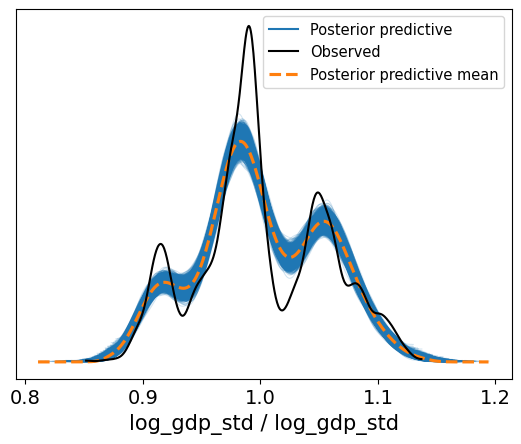

In [68]:
m_score_vs.predict(m_score_vs_fit, kind="pps")
az.plot_ppc(m_score_vs_fit);

The superior model fit becomes palpably apparent when we map the posterior predictions against the observations per region. In most instances, the varying slopes seem to align seamlessly with the data. A vital insight garnered from this plot is that the relationship between GDP and cultural production isn't universally positive across all regions. A pronounced positive correlation between the two variables is noticeable for the Low Countries, the United Kingdom, Japan, and to a slightly lesser degree, Spain. Conversely, the relationship appears inverted for the Chinese World, Eastern Europe, Italy, and the Arabic World. Portugal, France, and Central Europe do not appear to exhibit a distinct relationship, neither positive nor negative.

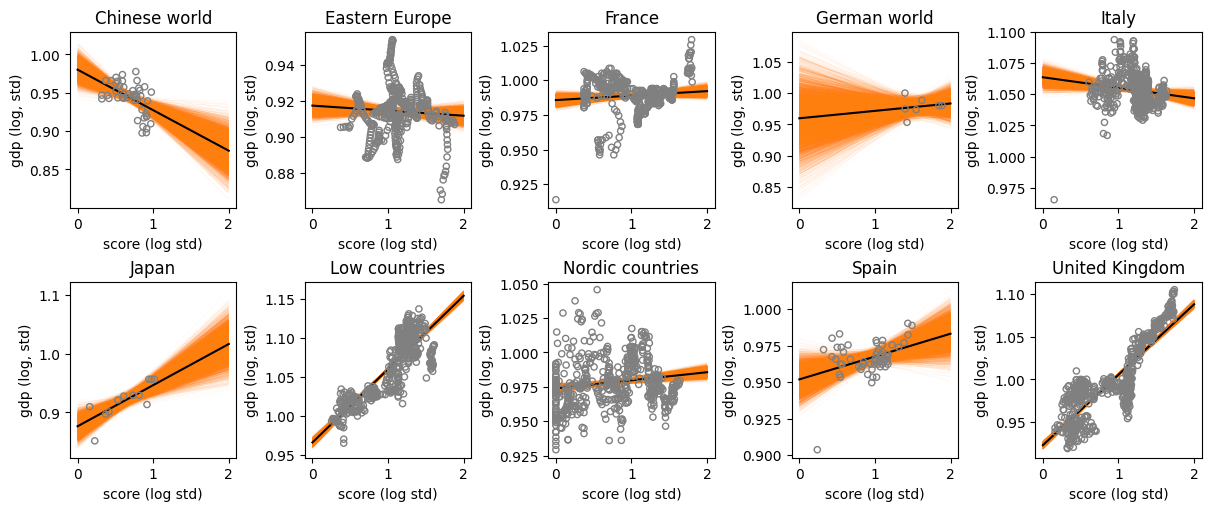

In [69]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

The ensuing plot illustrates the mean posterior distribution for each region, facilitating a more discernible understanding of regions that showcase a positive correlation between GDP and cultural production, and those that bear a negative or ambiguous relationship. The plot vividly indicates that some regions maintain a positive association, while others harbor a negative one. Thus, this analysis affirms that the incorporation of varying slopes in our model was justified and introduces valuable nuance to our exploration. **It underlines that we cannot unequivocally assert a positive correlation between cultural production and GDP, as this relationship varies by region.**

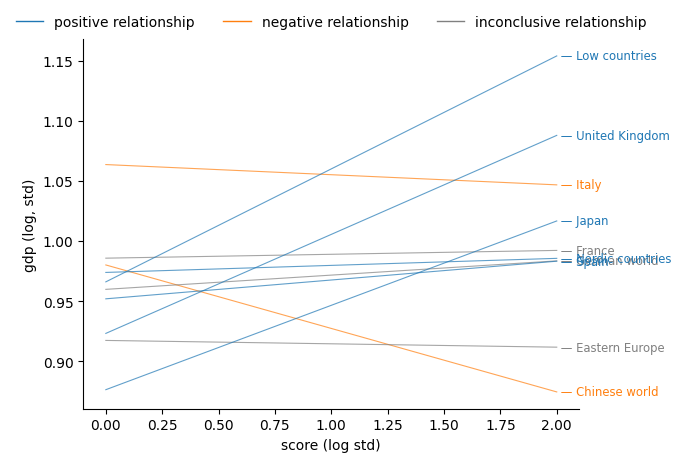

In [114]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score (log std)");

#### Covarying slopes and intercepts

To further scrutinize the region-specific slope attributes, we illustrate the covariance between region-specific intercepts and slopes. The hypothesis is the potential correlation between the intercepts and slopes, which may indicate, for instance, an enhanced or diminished GDP increase or decrease corresponding to higher or lower intercepts. The ensuing plot depicts this relationship. Although most regions don't seem to manifest a distinctly pronounced relationship between intercepts and slopes, there are a handful of intriguing cases where interaction is noticeable. For instance, in the German world, the Greek world, and in the Latin world, a negative correlation is observed, implying a decrease in slope as the intercept escalates. Contrarily, regions like the Low Countries, although having an average intercept (hence its position around zero), boast an above-average slope. On the other hand, the Chinese world, despite having an average intercept, showcases a below-average slope.

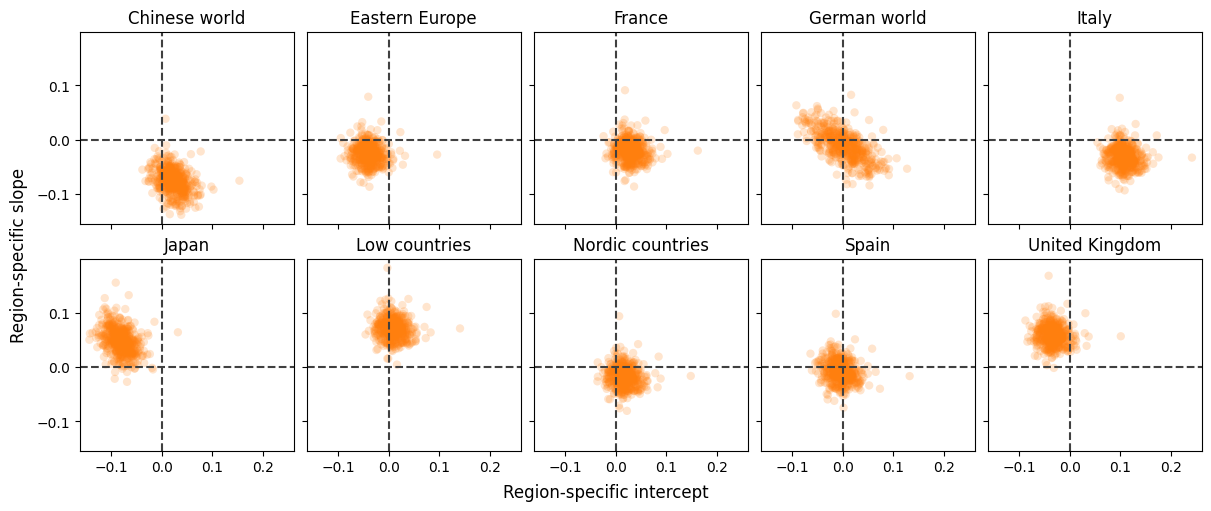

In [115]:
import matplotlib

regions = df["region_name"].unique()

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)

# #  extract a subsample from the posterior and stack the chain and draw dims
posterior = az.extract(m_score_vs_fit, num_samples=500)
for i, (region, ax) in enumerate(zip(regions, axes.flatten())):
    post = posterior.sel(region_name__factor_dim=region)
    X = post["1|region_name"].data
    Y = post["score_log_std|region_name"].data
    ax.scatter(
        X, Y,
        facecolor="C1", edgecolor="none", alpha=0.2)
    ax.set(title=region)

    ax.axhline(c="0.25", ls="--")
    ax.axvline(c="0.25", ls="--")
    
fig.supylabel('Region-specific slope')
fig.supxlabel('Region-specific intercept');
plt.savefig("covariance-plot.pdf")

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

In [116]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vs = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_vs

       Formula: log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            N_est_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [117]:
m_est_vs_fit = m_est_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (N_est_log_std|region_name)"] = m_est_vs_fit
az.summary(m_est_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_log_std|region_name_sigma, N_est_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 893 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  \
Intercept                                    0.944  0.027   0.892    0.993   
N_est_log_std                                0.037  0.029  -0.016    0.090   
log_gdp_std_sigma                            0.018  0.000   0.017    0.018   
1|region_name_sigma                          0.079  0.024   0.042    0.120   
N_est_log_std|region_name_sigma              0.085  0.027   0.044    0.129   
1|region_name[Chinese world]                 0.043  0.029  -0.011    0.097   
1|region_name[Eastern Europe]               -0.027  0.027  -0.081    0.023   
1|region_name[France]                        0.040  0.027  -0.011    0.091   
1|region_name[German world]                 -0.002  0.058  -0.109    0.107   
1|region_name[Italy]                         0.125  0.027   0.075    0.178   
1|region_name[Japan]                        -0.100  0.032  -0.160   -0.038   
1|region_name[Low countries]                -0.022  0.027  -0.072    0.030   
1|region_name[Nordic countries]              0.026  0.027  -0.025    0.077   
1|region_name[Spain]                         0.001  0.029  -0.055    0.053   
1|region_name[United Kingdom]               -0.078  0.027  -0.128   -0.026   
N_est_log_std|region_name[Chinese world]    -0.097  0.032  -0.155   -0.037   
N_est_log_std|region_name[Eastern Europe]   -0.040  0.029  -0.094    0.012   
N_est_log_std|region_name[France]           -0.032  0.029  -0.083    0.024   
N_est_log_std|region_name[German world]     -0.012  0.045  -0.095    0.074   
N_est_log_std|region_name[Italy]            -0.051  0.029  -0.103    0.004   
N_est_log_std|region_name[Japan]             0.064  0.037  -0.008    0.129   
N_est_log_std|region_name[Low countries]     0.114  0.029   0.061    0.167   
N_est_log_std|region_name[Nordic countries] -0.027  0.029  -0.080    0.026   
N_est_log_std|region_name[Spain]            -0.015  0.030  -0.069    0.045   
N_est_log_std|region_name[United Kingdom]    0.103  0.029   0.049    0.154   

                                             mcse_mean  mcse_sd  ess_bulk  \
Intercept                                        0.001    0.000    2289.0   
N_est_log_std                                    0.001    0.000    2057.0   
log_gdp_std_sigma                                0.000    0.000   10379.0   
1|region_name_sigma                              0.000    0.000    3218.0   
N_est_log_std|region_name_sigma                  0.001    0.000    2998.0   
1|region_name[Chinese world]                     0.001    0.000    2575.0   
1|region_name[Eastern Europe]                    0.001    0.000    2311.0   
1|region_name[France]                            0.001    0.000    2299.0   
1|region_name[German world]                      0.001    0.001    6458.0   
1|region_name[Italy]                             0.001    0.000    2314.0   
1|region_name[Japan]                             0.001    0.000    3047.0   
1|region_name[Low countries]                     0.001    0.000    2314.0   
1|region_name[Nordic countries]                  0.001    0.000    2292.0   
1|region_name[Spain]                             0.001    0.000    2520.0   
1|region_name[United Kingdom]                    0.001    0.000    2316.0   
N_est_log_std|region_name[Chinese world]         0.001    0.000    2438.0   
N_est_log_std|region_name[Eastern Europe]        0.001    0.000    2059.0   
N_est_log_std|region_name[France]                0.001    0.000    2057.0   
N_est_log_std|region_name[German world]          0.001    0.001    4352.0   
N_est_log_std|region_name[Italy]                 0.001    0.000    2117.0   
N_est_log_std|region_name[Japan]                 0.001    0.001    2972.0   
N_est_log_std|region_name[Low countries]         0.001    0.001    2100.0   
N_est_log_std|region_name[Nordic countries]      0.001    0.000    2054.0   
N_est_log_std|region_name[Spain]                 0.001    0.001    2222.0   
N_est_log_std|region_name[United Kingdom]        0.001    0.001    2084.0   

              

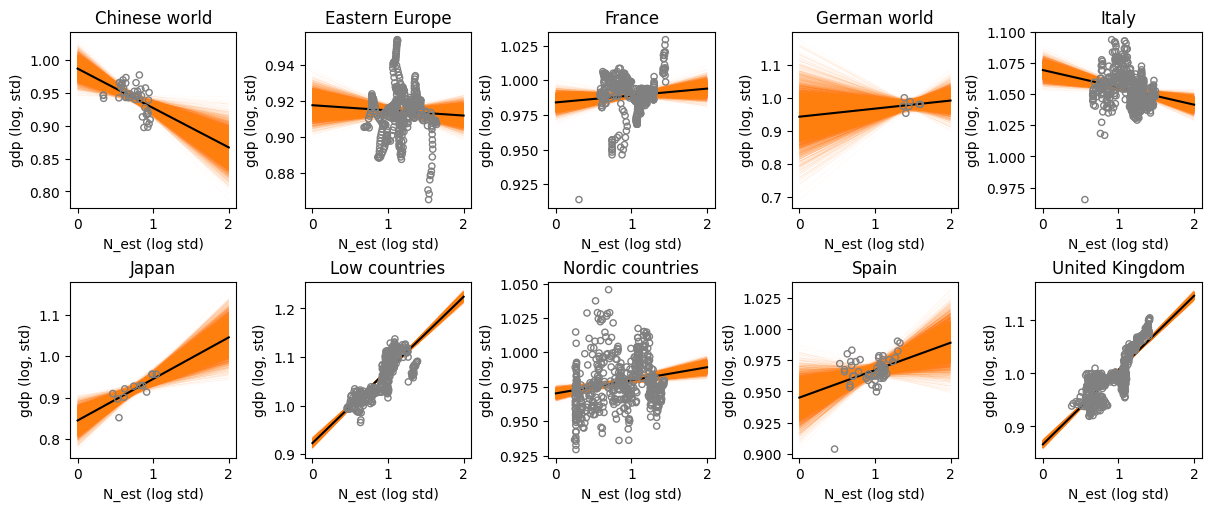

In [119]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est (log std)", title=region_name)

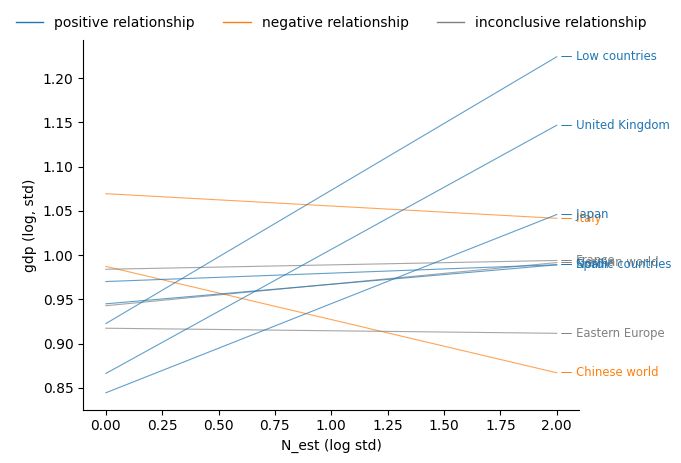

In [120]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est (log std)");

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models.

In [121]:
waic_compare = az.compare(models, ic='LOO')
waic_compare

rank     elpd_loo  \
log_gdp_std ~ score_log_std + (score_log_std|re...     0  8554.504539   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...     1  8413.186519   
log_gdp_std ~ score_log_std + (1|region_name)          2  7589.360798   
log_gdp_std ~ N_est_log_std + (1|region_name)          3  7451.883351   
log_gdp_std ~ (1|region_name)                          4  7146.618238   
gdp ~ score_log_std                                    5  4991.770865   
gdp ~ N_est_log_std                                    6  4862.281196   

                                                        p_loo    elpd_diff  \
log_gdp_std ~ score_log_std + (score_log_std|re...  22.461946     0.000000   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  21.488927   141.318020   
log_gdp_std ~ score_log_std + (1|region_name)       11.518810   965.143740   
log_gdp_std ~ N_est_log_std + (1|region_name)       11.315484  1102.621188   
log_gdp_std ~ (1|region_name)                       10.083927  1407.886301   
gdp ~ score_log_std                                  2.673174  3562.733674   
gdp ~ N_est_log_std                                  2.617400  3692.223343   

                                                      weight         se  \
log_gdp_std ~ score_log_std + (score_log_std|re...  0.953215  49.099694   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  0.000000  49.444051   
log_gdp_std ~ score_log_std + (1|region_name)       0.025648  41.155950   
log_gdp_std ~ N_est_log_std + (1|region_name)       0.000000  43.842027   
log_gdp_std ~ (1|region_name)                       0.021137  54.531812   
gdp ~ score_log_std                                 0.000000  37.680358   
gdp ~ N_est_log_std                                 0.000000  35.902716   

                                                          dse  warning scale  
log_gdp_std ~ score_log_std + (score_log_std|re...   0.000000    False   log  
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  12.087334    False   log  
log_gdp_std ~ score_log_std + (1|region_name)       46.314781    False   log  
log_gdp_std ~ N_est_log_std + (1|region_name)       49.632260    False   log  
log_gdp_std ~ (1|region_name)                       60.479862    False   log  
gdp ~ score_log_std                                 59.862233    False   log  
gdp ~ N_est_log_std                                 58.251390    False   log

/usr/local/lib/python3.11/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)


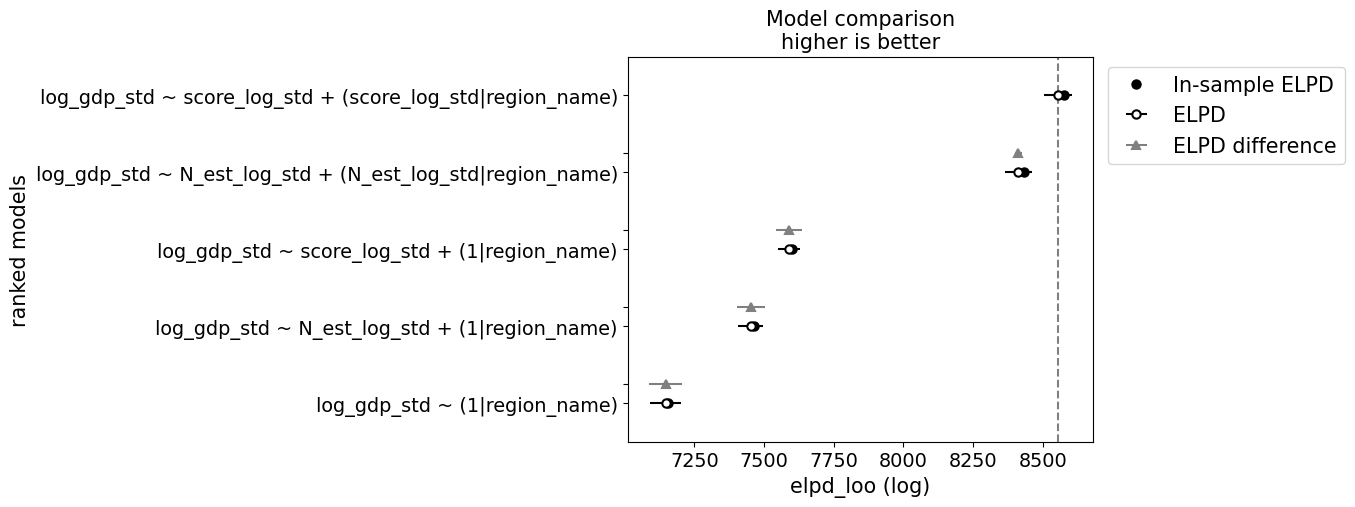

In [122]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True);

# Cultural score per capita

In the analsyses above, we correlated a global cultural production score (both corrected and uncorrected) with the GDP scores per capita. These scores ignore differences in population size. As a final step in the analysis, we repeat the analyses with varying intercepts and varying slopes, but swapping the unnormalized cultural production scores for the scores per capita. We begin with the uncorrected score:

In [123]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_cap_vi = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True, 
    priors=priors
)
m_score_cap_vi

       Formula: log_gdp_std ~ score_cap_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

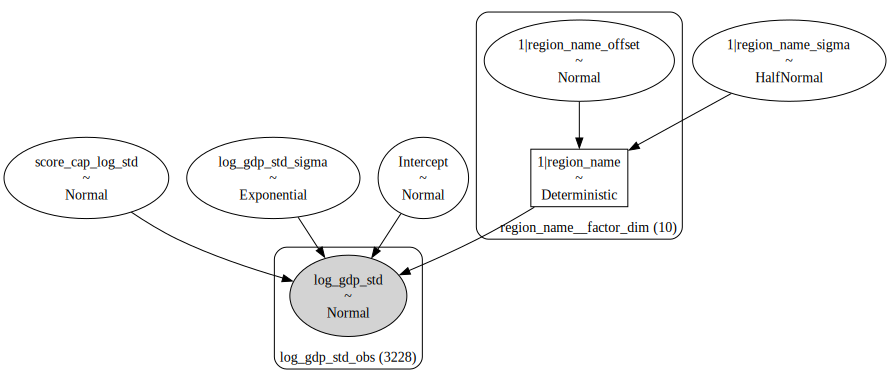

In [124]:
m_score_cap_vi.build()
m_score_cap_vi.graph()

In [125]:
m_score_cap_vi_fit = m_score_cap_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ score_cap_log_std + (1|region_name)"] = m_score_cap_vi_fit
az.summary(m_score_cap_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_cap_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 178 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.963  0.017   0.931    0.995        0.0   
score_cap_log_std                0.023  0.001   0.022    0.025        0.0   
log_gdp_std_sigma                0.023  0.000   0.023    0.024        0.0   
1|region_name_sigma              0.050  0.015   0.029    0.077        0.0   
1|region_name[Chinese world]     0.000  0.017  -0.033    0.032        0.0   
1|region_name[Eastern Europe]   -0.068  0.017  -0.101   -0.038        0.0   
1|region_name[France]            0.010  0.017  -0.022    0.042        0.0   
1|region_name[German world]     -0.022  0.018  -0.056    0.014        0.0   
1|region_name[Italy]             0.064  0.017   0.031    0.095        0.0   
1|region_name[Japan]            -0.042  0.018  -0.077   -0.009        0.0   
1|region_name[Low countries]     0.068  0.017   0.036    0.100        0.0   
1|region_name[Nordic countries] -0.008  0.017  -0.041    0.023        0.0   
1|region_name[Spain]            -0.015  0.017  -0.047    0.016        0.0   
1|region_name[United Kingdom]    0.014  0.017  -0.018    0.046        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1252.0    1392.0    1.0  
score_cap_log_std                    0.0    6347.0    5064.0    1.0  
log_gdp_std_sigma                    0.0    5574.0    4705.0    1.0  
1|region_name_sigma                  0.0    1337.0    2191.0    1.0  
1|region_name[Chinese world]         0.0    1288.0    1542.0    1.0  
1|region_name[Eastern Europe]        0.0    1247.0    1471.0    1.0  
1|region_name[France]                0.0    1252.0    1398.0    1.0  
1|region_name[German world]          0.0    1487.0    1865.0    1.0  
1|region_name[Italy]                 0.0    1254.0    1443.0    1.0  
1|region_name[Japan]                 0.0    1406.0    1564.0    1.0  
1|region_name[Low countries]         0.0    1249.0    1434.0    1.0  
1|region_name[Nordic countries]      0.0    1257.0    1468.0    1.0  
1|region_name[Spain]                 0.0    1279.0    1490.0    1.0  
1|region_name[United Kingdom]        0.0    1258.0    1422.0    1.0

Once again, the sampling appears to be successful, reflected by desirable $\hat{r}$ values and substantial effective sample sizes. The findings hint at a minimal positive global correlation between cultural production and GDP (0.023 CI [0.022, 0.025]). It seems that the model fit is decent. 

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


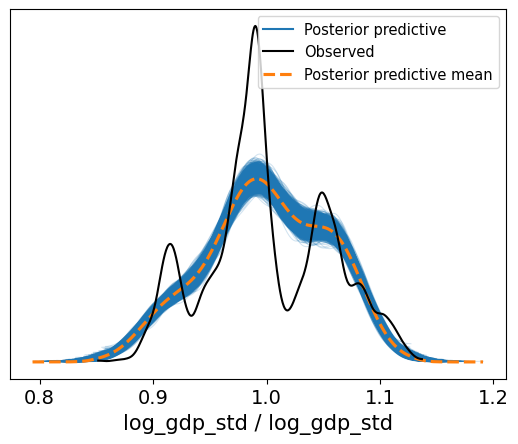

In [126]:
m_score_cap_vi.predict(m_score_cap_vi_fit, kind="pps")
az.plot_ppc(m_score_cap_vi_fit);

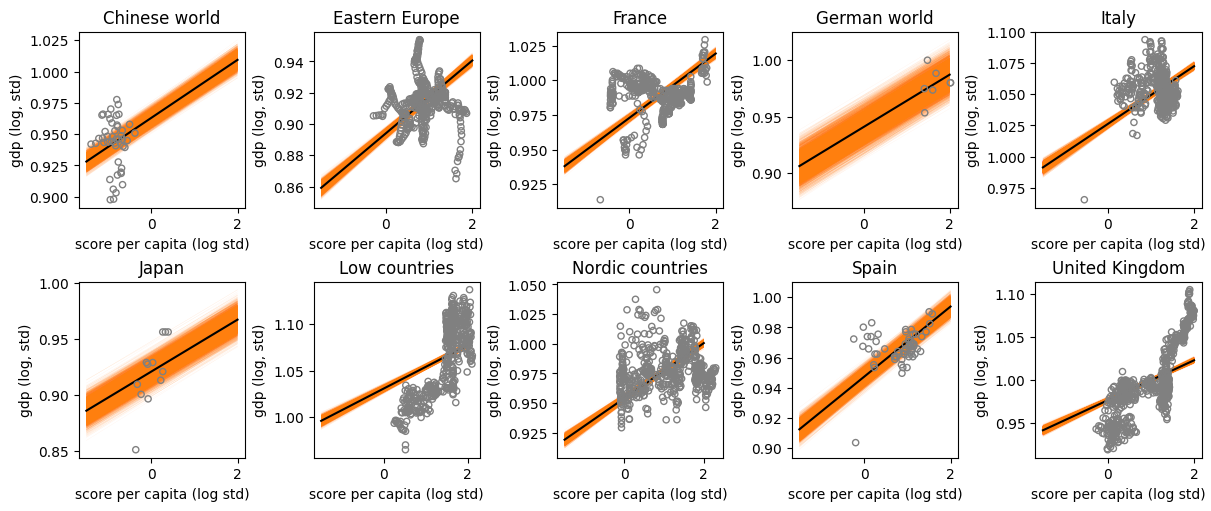

In [130]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_cap_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score per capita (log std)", title=region_name)

Here's another visualization of the posterior predictions: the intercepts differ, but the slope (_by design_) is the same, and thus always positive:

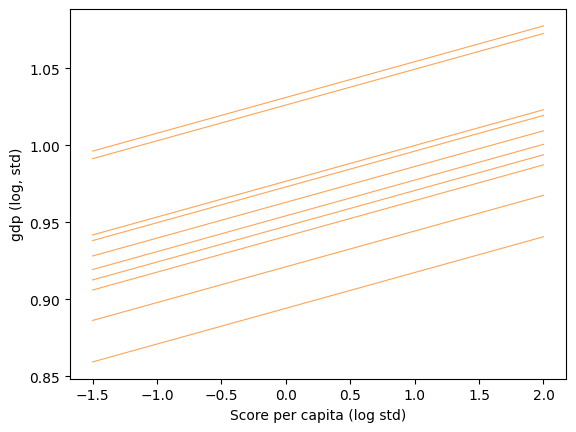

In [131]:
posterior = az.extract(m_score_cap_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["score_cap_log_std"]
score = np.array([-1.5, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("Score per capita (log std)");

We perform the same analysis, swapping the cultural production score for the bias-corrected score:

In [132]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_cap_vi = bmb.Model(
    "log_gdp_std ~ N_est_cap_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors)
m_est_cap_vi

       Formula: log_gdp_std ~ N_est_cap_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [133]:
m_est_cap_vi_fit = m_est_cap_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_cap_log_std + (1|region_name)"] = m_est_cap_vi_fit
az.summary(m_est_cap_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_cap_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 188 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.950  0.018   0.916    0.985      0.001   
N_est_cap_log_std                0.036  0.002   0.033    0.038      0.000   
log_gdp_std_sigma                0.024  0.000   0.024    0.025      0.000   
1|region_name_sigma              0.054  0.015   0.030    0.082      0.000   
1|region_name[Chinese world]    -0.006  0.019  -0.041    0.029      0.001   
1|region_name[Eastern Europe]   -0.073  0.018  -0.108   -0.039      0.001   
1|region_name[France]            0.009  0.018  -0.026    0.043      0.001   
1|region_name[German world]     -0.022  0.020  -0.059    0.017      0.001   
1|region_name[Italy]             0.064  0.018   0.029    0.098      0.001   
1|region_name[Japan]            -0.046  0.019  -0.083   -0.009      0.001   
1|region_name[Low countries]     0.076  0.018   0.041    0.110      0.001   
1|region_name[Nordic countries] -0.008  0.018  -0.044    0.025      0.001   
1|region_name[Spain]            -0.017  0.019  -0.050    0.020      0.001   
1|region_name[United Kingdom]    0.015  0.018  -0.020    0.049      0.001   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1163.0    1896.0    1.0  
N_est_cap_log_std                    0.0    5997.0    5161.0    1.0  
log_gdp_std_sigma                    0.0    5835.0    4745.0    1.0  
1|region_name_sigma                  0.0    1601.0    2723.0    1.0  
1|region_name[Chinese world]         0.0    1193.0    1801.0    1.0  
1|region_name[Eastern Europe]        0.0    1161.0    1768.0    1.0  
1|region_name[France]                0.0    1156.0    1862.0    1.0  
1|region_name[German world]          0.0    1333.0    2179.0    1.0  
1|region_name[Italy]                 0.0    1155.0    1867.0    1.0  
1|region_name[Japan]                 0.0    1268.0    1812.0    1.0  
1|region_name[Low countries]         0.0    1157.0    1894.0    1.0  
1|region_name[Nordic countries]      0.0    1156.0    1836.0    1.0  
1|region_name[Spain]                 0.0    1173.0    1899.0    1.0  
1|region_name[United Kingdom]        0.0    1154.0    1874.0    1.0

The fit appears to bear similarity to the prior model, and once more, the incorporated unidirectional relationship yields comparatively large residuals.

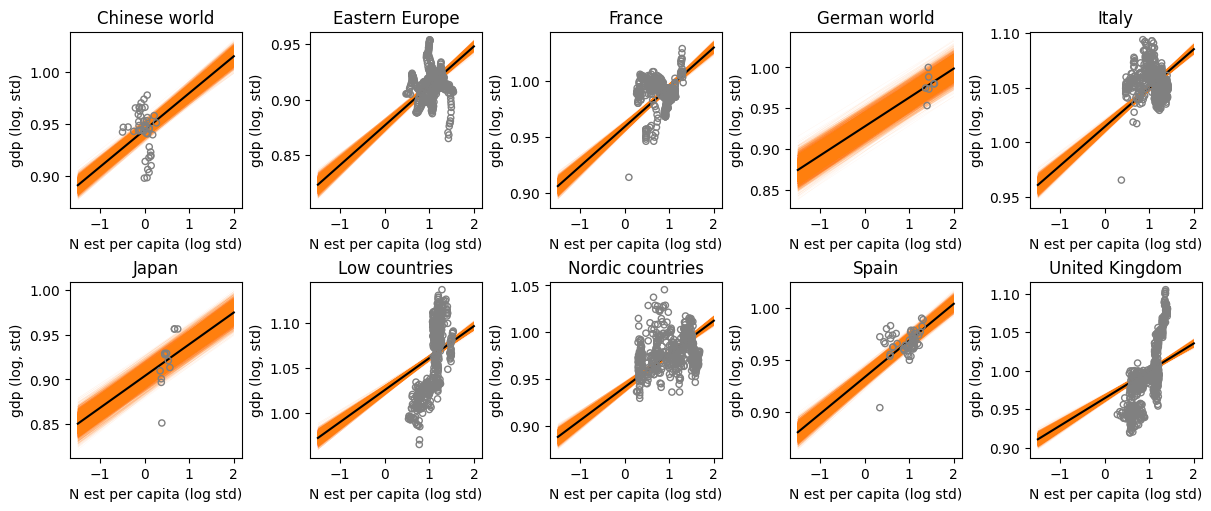

In [134]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_cap_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N est per capita (log std)", title=region_name)

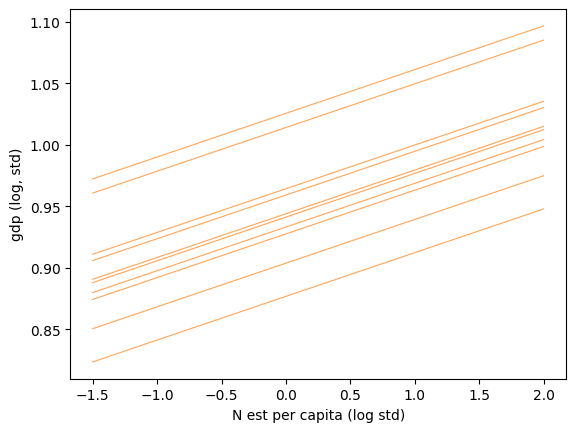

In [136]:
posterior = az.extract(m_est_cap_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_cap_log_std"]
score = np.array([-1.5, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("N est per capita (log std)");

### Varying Slopes for Cultural Production in Different Regions

In [137]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_cap_vs = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_cap_vs

       Formula: log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            score_cap_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

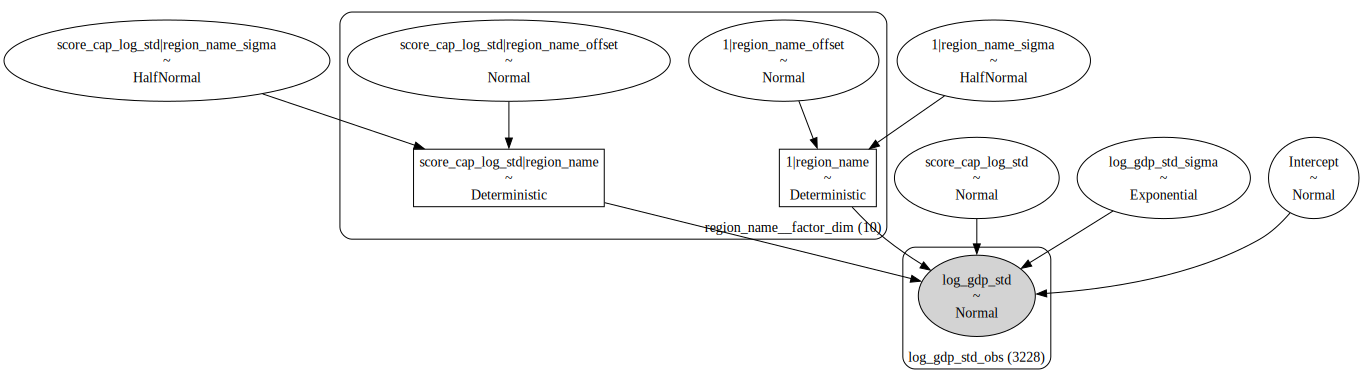

In [138]:
m_score_cap_vs.build()
m_score_cap_vs.graph()

In [139]:
m_score_cap_vs_fit = m_score_cap_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)"] = m_score_cap_vs_fit
az.summary(m_score_cap_vs_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_cap_log_std, 1|region_name_sigma, 1|region_name_offset, score_cap_log_std|region_name_sigma, score_cap_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 499 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  \
Intercept                                        0.962  0.017   0.930   
score_cap_log_std                                0.021  0.013  -0.002   
log_gdp_std_sigma                                0.018  0.000   0.017   
1|region_name_sigma                              0.049  0.014   0.026   
score_cap_log_std|region_name_sigma              0.037  0.012   0.020   
1|region_name[Chinese world]                    -0.021  0.019  -0.057   
1|region_name[Eastern Europe]                   -0.046  0.017  -0.077   
1|region_name[France]                            0.026  0.017  -0.006   
1|region_name[German world]                     -0.005  0.031  -0.063   
1|region_name[Italy]                             0.094  0.017   0.059   
1|region_name[Japan]                            -0.043  0.017  -0.073   
1|region_name[Low countries]                     0.007  0.017  -0.024   
1|region_name[Nordic countries]                  0.012  0.017  -0.019   
1|region_name[Spain]                            -0.002  0.017  -0.035   
1|region_name[United Kingdom]                   -0.017  0.017  -0.048   
score_cap_log_std|region_name[Chinese world]    -0.025  0.016  -0.056   
score_cap_log_std|region_name[Eastern Europe]   -0.023  0.013  -0.046   
score_cap_log_std|region_name[France]           -0.019  0.013  -0.042   
score_cap_log_std|region_name[German world]     -0.008  0.020  -0.046   
score_cap_log_std|region_name[Italy]            -0.023  0.013  -0.046   
score_cap_log_std|region_name[Japan]             0.050  0.021   0.010   
score_cap_log_std|region_name[Low countries]     0.045  0.013   0.021   
score_cap_log_std|region_name[Nordic countries] -0.017  0.013  -0.041   
score_cap_log_std|region_name[Spain]            -0.013  0.013  -0.038   
score_cap_log_std|region_name[United Kingdom]    0.035  0.013   0.012   

                                                 hdi_97%  mcse_mean  mcse_sd  \
Intercept                                          0.993        0.0      0.0   
score_cap_log_std                                  0.045        0.0      0.0   
log_gdp_std_sigma                                  0.018        0.0      0.0   
1|region_name_sigma                                0.073        0.0      0.0   
score_cap_log_std|region_name_sigma                0.059        0.0      0.0   
1|region_name[Chinese world]                       0.015        0.0      0.0   
1|region_name[Eastern Europe]                     -0.014        0.0      0.0   
1|region_name[France]                              0.057        0.0      0.0   
1|region_name[German world]                        0.054        0.0      0.0   
1|region_name[Italy]                               0.124        0.0      0.0   
1|region_name[Japan]                              -0.008        0.0      0.0   
1|region_name[Low countries]                       0.040        0.0      0.0   
1|region_name[Nordic countries]                    0.043        0.0      0.0   
1|region_name[Spain]                               0.030        0.0      0.0   
1|region_name[United Kingdom]                      0.015        0.0      0.0   
score_cap_log_std|region_name[Chinese world]       0.005        0.0      0.0   
score_cap_log_std|region_name[Eastern Europe]      0.001        0.0      0.0   
score_cap_log_std|region_name[France]              0.005        0.0      0.0   
score_cap_log_std|region_name[German world]        0.030        0.0      0.0   
score_cap_log_std|region_name[Italy]               0.001        0.0      0.0   
score_cap_log_std|region_name[Japan]               0.089        0.0      0.0   
score_cap_log_std|region_name[Low countries]       0.068        0.0      0.0   
score_cap_log_std|region_name[Nordic countries]    0.006        0.0      0.0   
score_cap_log_std|region_name[Spain]               0.012        0.0      0.0   
score_cap_log_std|region_name[United Kingdom]      0.059        0.0      0.0   

                                                 ess_bulk  ess_tail  r

Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

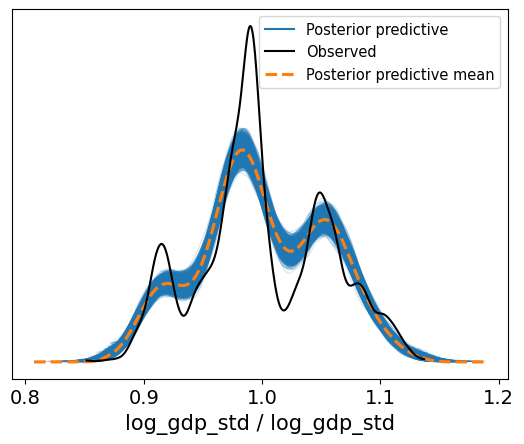

In [140]:
m_score_cap_vs.predict(m_score_cap_vs_fit, kind="pps")
az.plot_ppc(m_score_cap_vs_fit);

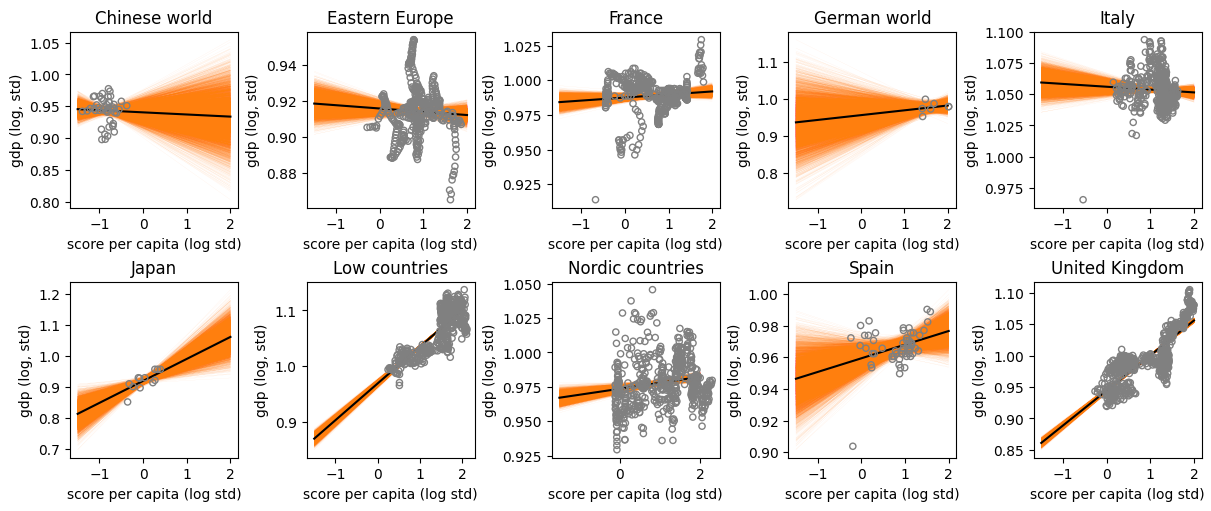

In [141]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_cap_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_cap_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score per capita (log std)", title=region_name)

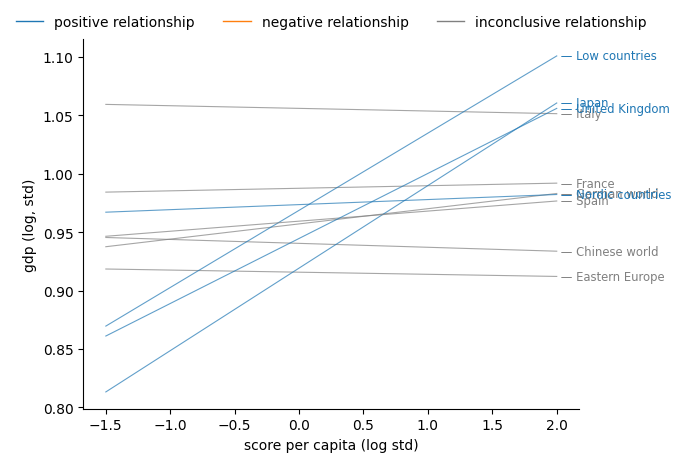

In [142]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_cap_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score per capita (log std)");

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

In [143]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_cap_vs = bmb.Model(
    "log_gdp_std ~  N_est_cap_log_std + (N_est_cap_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_cap_vs

       Formula: log_gdp_std ~  N_est_cap_log_std + (N_est_cap_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            N_est_cap_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [144]:
m_est_cap_vs_fit = m_est_cap_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_cap_log_std + (N_est_cap_log_std|region_name)"] = m_est_cap_vs_fit
az.summary(m_est_cap_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_cap_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_cap_log_std|region_name_sigma, N_est_cap_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 836 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


mean     sd  hdi_3%  \
Intercept                                        0.942  0.024   0.894   
N_est_cap_log_std                                0.040  0.026  -0.011   
log_gdp_std_sigma                                0.019  0.000   0.018   
1|region_name_sigma                              0.071  0.022   0.039   
N_est_cap_log_std|region_name_sigma              0.077  0.024   0.041   
1|region_name[Chinese world]                     0.000  0.024  -0.045   
1|region_name[Eastern Europe]                   -0.026  0.024  -0.072   
1|region_name[France]                            0.044  0.024   0.000   
1|region_name[German world]                     -0.008  0.056  -0.115   
1|region_name[Italy]                             0.122  0.024   0.076   
1|region_name[Japan]                            -0.085  0.030  -0.139   
1|region_name[Low countries]                    -0.029  0.024  -0.075   
1|region_name[Nordic countries]                  0.027  0.024  -0.016   
1|region_name[Spain]                             0.010  0.025  -0.037   
1|region_name[United Kingdom]                   -0.063  0.024  -0.106   
N_est_cap_log_std|region_name[Chinese world]    -0.073  0.030  -0.130   
N_est_cap_log_std|region_name[Eastern Europe]   -0.042  0.026  -0.094   
N_est_cap_log_std|region_name[France]           -0.036  0.027  -0.088   
N_est_cap_log_std|region_name[German world]     -0.009  0.044  -0.092   
N_est_cap_log_std|region_name[Italy]            -0.050  0.026  -0.098   
N_est_cap_log_std|region_name[Japan]             0.087  0.043   0.007   
N_est_cap_log_std|region_name[Low countries]     0.098  0.027   0.047   
N_est_cap_log_std|region_name[Nordic countries] -0.032  0.026  -0.079   
N_est_cap_log_std|region_name[Spain]            -0.025  0.028  -0.077   
N_est_cap_log_std|region_name[United Kingdom]    0.082  0.026   0.032   

                                                 hdi_97%  mcse_mean  mcse_sd  \
Intercept                                          0.986      0.000    0.000   
N_est_cap_log_std                                  0.089      0.001    0.000   
log_gdp_std_sigma                                  0.019      0.000    0.000   
1|region_name_sigma                                0.109      0.000    0.000   
N_est_cap_log_std|region_name_sigma                0.118      0.000    0.000   
1|region_name[Chinese world]                       0.047      0.000    0.000   
1|region_name[Eastern Europe]                      0.021      0.000    0.000   
1|region_name[France]                              0.093      0.000    0.000   
1|region_name[German world]                        0.097      0.001    0.001   
1|region_name[Italy]                               0.169      0.000    0.000   
1|region_name[Japan]                              -0.026      0.001    0.000   
1|region_name[Low countries]                       0.018      0.000    0.000   
1|region_name[Nordic countries]                    0.076      0.000    0.000   
1|region_name[Spain]                               0.060      0.000    0.000   
1|region_name[United Kingdom]                     -0.015      0.000    0.000   
N_est_cap_log_std|region_name[Chinese world]      -0.015      0.001    0.000   
N_est_cap_log_std|region_name[Eastern Europe]      0.007      0.001    0.000   
N_est_cap_log_std|region_name[France]              0.012      0.001    0.000   
N_est_cap_log_std|region_name[German world]        0.072      0.001    0.001   
N_est_cap_log_std|region_name[Italy]               0.002      0.001    0.000   
N_est_cap_log_std|region_name[Japan]               0.168      0.001    0.000   
N_est_cap_log_std|region_name[Low countries]       0.148      0.001    0.000   
N_est_cap_log_std|region_name[Nordic countries]    0.020      0.001    0.000   
N_est_cap_log_std|region_name[Spain]               0.027      0.001    0.000   
N_est_cap_log_std|region_name[United Kingdom]      0.132      0.001    0.000   

                                                 ess_bulk  ess_tail  r

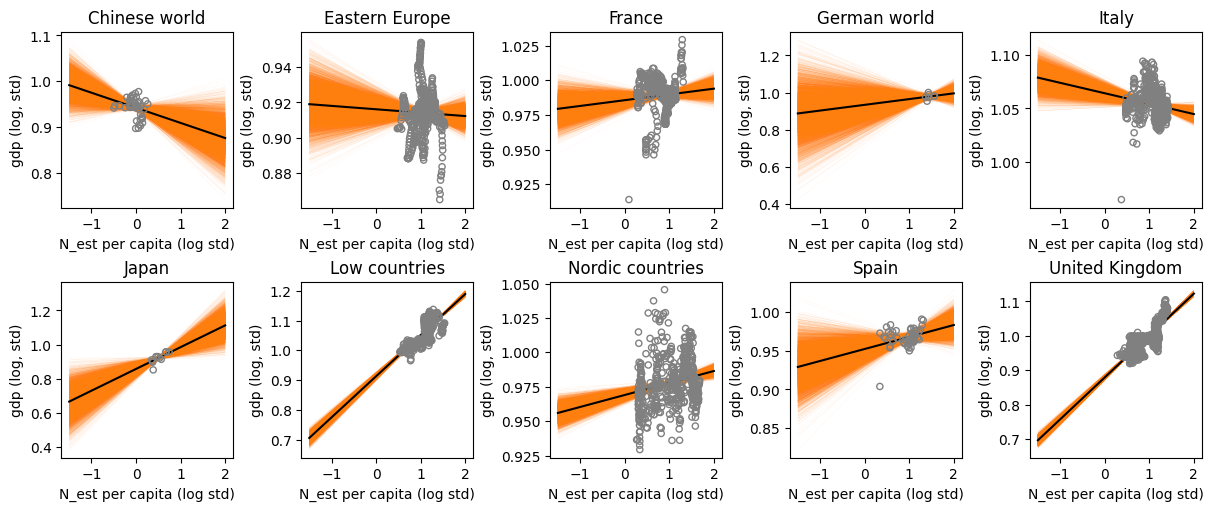

In [145]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_cap_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_cap_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est per capita (log std)", title=region_name)

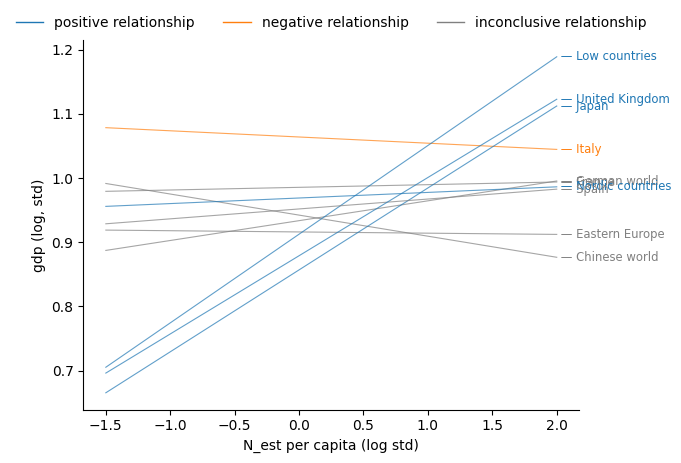

In [146]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_cap_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est per capita (log std)");

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models. Furthermore, we note that the bias-correction does not improve the model fit considerably. Finally, representing the cultural scores per capita does not improve the model fit either. 

In [147]:
waic_compare = az.compare(models, ic='LOO')
waic_compare

rank     elpd_loo  \
log_gdp_std ~ score_log_std + (score_log_std|re...     0  8554.504539   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...     1  8413.186519   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...     2  8398.062929   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...     3  8216.240787   
log_gdp_std ~ score_log_std + (1|region_name)          4  7589.360798   
log_gdp_std ~ score_cap_log_std + (1|region_name)      5  7556.022469   
log_gdp_std ~ N_est_log_std + (1|region_name)          6  7451.883351   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)      7  7398.914004   
log_gdp_std ~ (1|region_name)                          8  7146.618238   
gdp ~ score_log_std                                    9  4991.770865   
gdp ~ N_est_log_std                                   10  4862.281196   

                                                        p_loo    elpd_diff  \
log_gdp_std ~ score_log_std + (score_log_std|re...  22.461946     0.000000   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  21.488927   141.318020   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...  20.747187   156.441609   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...  19.737297   338.263752   
log_gdp_std ~ score_log_std + (1|region_name)       11.518810   965.143740   
log_gdp_std ~ score_cap_log_std + (1|region_name)   11.433324   998.482070   
log_gdp_std ~ N_est_log_std + (1|region_name)       11.315484  1102.621188   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   10.961610  1155.590535   
log_gdp_std ~ (1|region_name)                       10.083927  1407.886301   
gdp ~ score_log_std                                  2.673174  3562.733674   
gdp ~ N_est_log_std                                  2.617400  3692.223343   

                                                          weight         se  \
log_gdp_std ~ score_log_std + (score_log_std|re...  9.536185e-01  49.099694   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  2.144533e-08  49.444051   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...  1.911414e-08  47.747320   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...  1.092704e-14  47.681629   
log_gdp_std ~ score_log_std + (1|region_name)       1.384886e-02  41.155950   
log_gdp_std ~ score_cap_log_std + (1|region_name)   1.146453e-02  42.616940   
log_gdp_std ~ N_est_log_std + (1|region_name)       4.534194e-08  43.842027   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   4.258399e-08  45.868734   
log_gdp_std ~ (1|region_name)                       2.106803e-02  54.531812   
gdp ~ score_log_std                                 7.297868e-08  37.680358   
gdp ~ N_est_log_std                                 0.000000e+00  35.902716   

                                                          dse  warning scale  
log_gdp_std ~ score_log_std + (score_log_std|re...   0.000000    False   log  
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  12.087334    False   log  
log_gdp_std ~ score_cap_log_std + (score_cap_lo...  14.377244    False   log  
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...  18.172420    False   log  
log_gdp_std ~ score_log_std + (1|region_name)       46.314781    False   log  
log_gdp_std ~ score_cap_log_std + (1|region_name)   47.531551    False   log  
log_gdp_std ~ N_est_log_std + (1|region_name)       49.632260    False   log  
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   51.536490    False   log  
log_gdp_std ~ (1|region_name)                       60.479862    False   log  
gdp ~ score_log_std                                 59.862233    False   log  
gdp ~ N_est_log_std                                 58.251390    False   log

/usr/local/lib/python3.11/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)


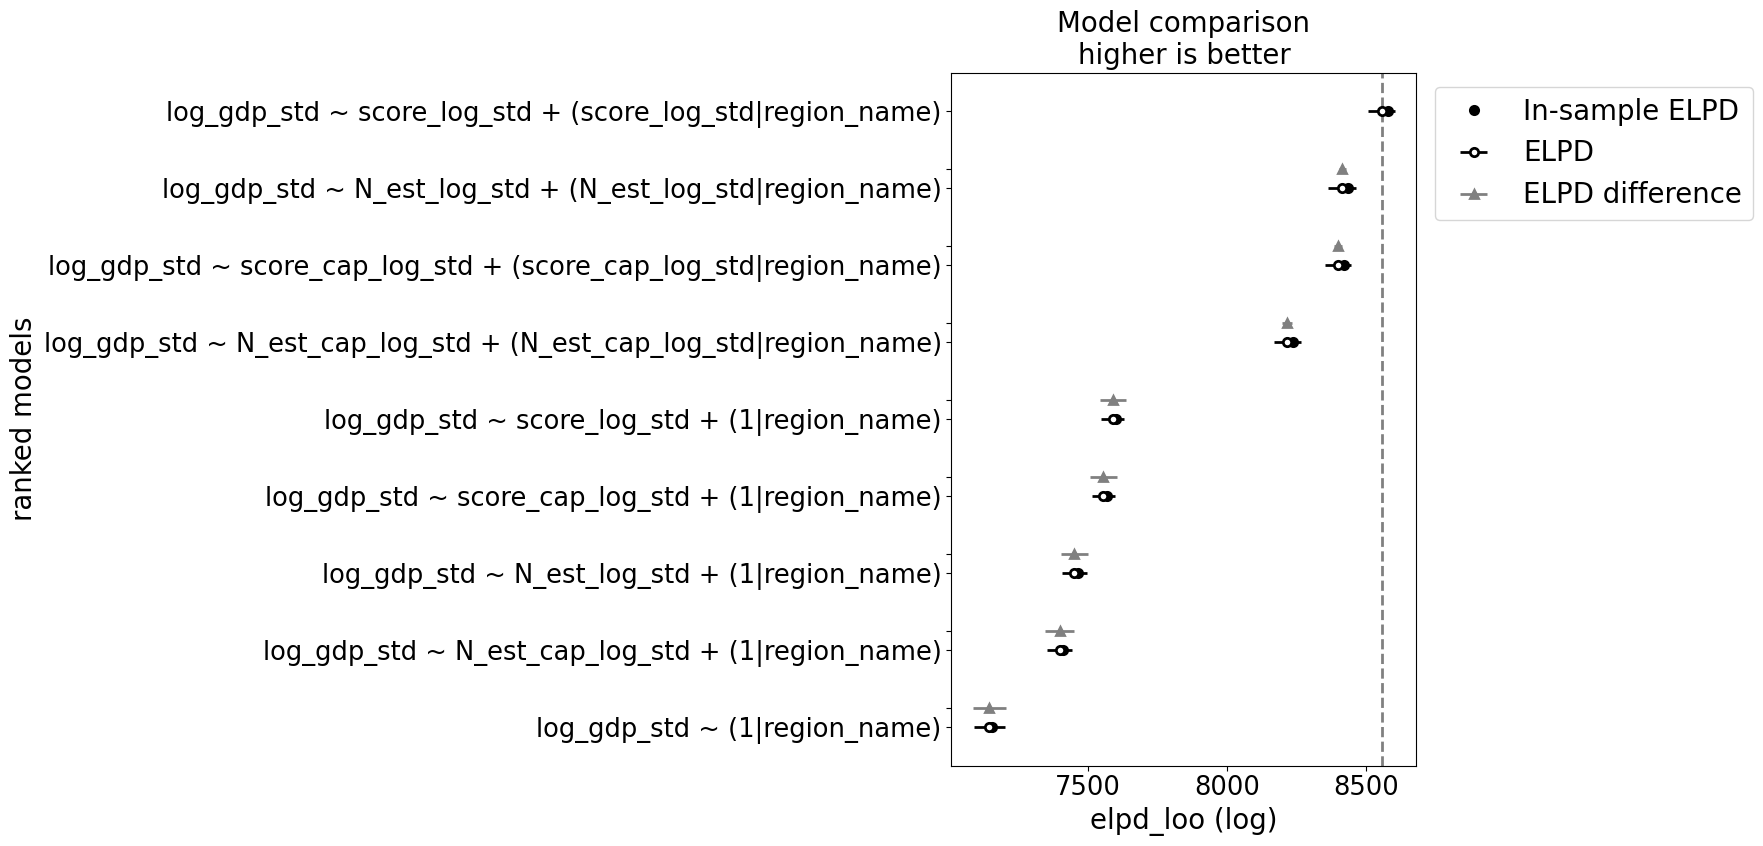

In [148]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True);